# Generate Asteroid CSV

This pipeline will scrape through JWST MIRI observations to identify what asteroids are present within the image at the moment of observation. The names of those specific asteroids, along with useful information regarding the observation will be saved in a CSV.

## Import Libraries

In [33]:
from astroquery.esa.jwst import Jwst
import numpy as np
from datetime import datetime
from tqdm import tqdm
import pandas as pd
from astropy.io import fits
import astropy.time as at
from astroquery.jplhorizons import Horizons
import re
import os
import logging
import glob
import shapely.wkt
from shapely.geometry import Polygon, Point
from reproject import reproject_interp
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import math as mt
from astropy.time import Time
from astroquery.imcce import Skybot
import astropy.units as u
from astropy.visualization import ZScaleInterval, ImageNormalize,LinearStretch, SqrtStretch
from astropy.nddata import Cutout2D
from PIL import Image
from matplotlib import cm
import numpy as np
from sbident import SBIdent
import time


import warnings
warnings.filterwarnings('ignore')

## Sign into JWST Archive

In [34]:
#Cosmos Account Credentials
Jwst.login(user='nmartind', password='Mr.Fantastic1999')

INFO: OK [astroquery.utils.tap.core]


## Utility Functions

In [35]:
def formatPolygon(string):
    #Format the saved polygon from the archive to the one suitable with shapely
    values_ = string.split(' ')
    string_ = string.replace('Polygon ','POLYGON((')
    
    # add in the commas at every other space
    string_ = re.sub(r'(\s\S*?)\s', r'\1, ',string_)
    
    #Add in the final chracter so that it matches the first (ie forms a closed polygon)
    string_ = string_ + f', {values_[1]} {values_[2]}))'
    string_ = string_.replace('POLYGON(', 'POLYGON (')
    return(string_)

In [36]:
def isLocatedInImage(targetRA, targetDEC, imagePOLYGON):
    #Check if the RA and DEC coordinate exist within the image bound polygon (returns boolean)
    return(imagePOLYGON.contains(Point(targetRA, targetDEC)))

In [37]:
def MJDconversion(modifiedJulianDate):
    #Convert Modified Julian Date to YYYMMDD[H:M:S] format
    date = at.Time(modifiedJulianDate, format = 'mjd')
    date.format = 'iso' # 'YYYY-MM-DD HH:MM:SS'
    return(date)

In [38]:
def pullWCS(imagePath):
    #Recover header, data, and WCS from an i2d fits file
    try:
        with fits.open(imagePath) as hdul:        
            data = hdul[1].data
            header = hdul[1].header
            wcs_info = WCS(header)
            
            print(header)
    
    #Sometimes the data that the archive expects to exist is not on Datalabs
    except:
        print(f'Data not found for {imagePath}')
        wcs_info = False
        data = False
   
    return(wcs_info, data)

In [39]:
def coordConversion(RAlist, DEClist, wcs_info):
    #Convert RA and DEC positions into pixel locations on image using the WCS data
    PosX, PosY = wcs_info.all_world2pix(RAlist, DEClist, 0)
        
    return(PosX, PosY)

In [49]:
def definePolyEdges(polygonString):
    #Define the image boundaries for the cone search
    
    #Pull in the polygon information and identify the RA and DEC positions
    polyPoints = polygonString.replace("POLYGON ((", "").replace("))","").replace(", "," ").split(' ')
    
    #Add a slight increase to the cone search since there are times when the image does not exactly line up
    #coneSearchBuffer = 0.0008
    coneSearchBufferRA = 0.0022
    coneSearchBufferDEC = 0.001
    
    #identify the corner points
    EdgePoint1 = SkyCoord(float(polyPoints[0]) + coneSearchBufferRA , float(polyPoints[1]) + coneSearchBufferDEC, frame='icrs', unit='deg') 
    EdgePoint2 = SkyCoord(float(polyPoints[2]) + coneSearchBufferRA , float(polyPoints[3]) - coneSearchBufferDEC, frame='icrs', unit='deg') 
    EdgePoint3 = SkyCoord(float(polyPoints[4]) - coneSearchBufferRA , float(polyPoints[5]) - coneSearchBufferDEC, frame='icrs', unit='deg')
    EdgePoint4 = SkyCoord(float(polyPoints[6]) - coneSearchBufferRA , float(polyPoints[7]) + coneSearchBufferDEC, frame='icrs', unit='deg')
    
    #coneCorners = [[float(polyPoints[0]) + coneSearchBufferRA, float(polyPoints[1]) + coneSearchBufferDEC ], [float(polyPoints[2]) + coneSearchBufferRA, float(polyPoints[3]) - coneSearchBufferDEC],[float(polyPoints[4]) - coneSearchBufferRA ,float(polyPoints[5]) -  coneSearchBufferDEC],[float(polyPoints[6]) - coneSearchBufferRA ,float(polyPoints[7]) + coneSearchBufferDEC ]]
    OriginalBuffer =  [[float(polyPoints[0]), float(polyPoints[1])  ], [float(polyPoints[2]) , float(polyPoints[3])],[float(polyPoints[4]) ,float(polyPoints[5]) ],[float(polyPoints[6]) ,float(polyPoints[7])]]
    
    RAS =  [float(polyPoints[0]), float(polyPoints[2]), float(polyPoints[4]), float(polyPoints[6])]
    DECS = [float(polyPoints[1]), float(polyPoints[3]), float(polyPoints[5]), float(polyPoints[7])]
    
    #Bottom right corner
    Corner1 = SkyCoord(float(min(RAS)-0.001) , float(min(DECS)-0.001), frame='icrs', unit='deg') 
    
    #top left corner
    Corner2 = SkyCoord(float(max(RAS)+0.001) , float(max(DECS)+0.001), frame='icrs', unit='deg')
    
    testCorners = [[min(RAS), min(DECS)],[min(RAS), max(DECS)],[max(RAS), max(DECS)],[max(RAS),min(DECS)]]
    coneCorners = [[float(polyPoints[0]) + coneSearchBufferRA , float(polyPoints[1]) + coneSearchBufferDEC], [float(polyPoints[0]) + coneSearchBufferRA , float(polyPoints[5]) - coneSearchBufferDEC],[float(polyPoints[4]) - coneSearchBufferRA ,float(polyPoints[5]) -  coneSearchBufferDEC],[float(polyPoints[4]) - coneSearchBufferRA, float(polyPoints[1]) +  coneSearchBufferDEC]]
    
    #The edges used for the cone search, takes in 2 opposite corners
    Bounds  = [Corner1, Corner2]
    
    return(coneCorners, Bounds, OriginalBuffer, testCorners)   

In [50]:
def JWSTposition(obsTime):
    #Determine the position of JWST during the observation time from an Earth perspective. Follows example 3 from  https://github.com/bengebre/sbident/blob/main/examples/sbident-examples.ipynb 
    au = (1*u.au).to(u.km).value #1AU in km 
    jwst = Horizons(id='JWST',location='Geocentric',epochs=obsTime.jd, id_type='id').vectors(refplane='earth') #state vector

    jwst_km = jwst[['x','y','z','vx','vy','vz']].to_pandas().to_numpy()*au #convert to km
    jwst_km[:,3:] = jwst_km[:,3:]/86400 #convert to km/s

    #Form the xobs dictionary that is the input for SBIdent location argument
    xobs = ','.join([np.format_float_scientific(s, precision=12) for s in jwst_km[0]])
    xobs_location = {'xobs': xobs}
    
    return(xobs_location)

## Generate ADQL Search

In [51]:
def queryArchive(display_amount, volume, readouts, query_filters, save_loc):
    #Generate a query search for the JWST archive to filter the observations and produce a pandas DF containing all useful information
    
    #Setting up constraints and filters for data selected for the CSV
    #logging.info('Constructing Filters')
    readout_string = ','.join(readouts)
    filter_string = ' AND '.join(query_filters)
    query_string = f"SELECT TOP {display_amount} {readout_string} FROM jwst.{volume} WHERE ({filter_string})"
    
    #Pull data formatted by the display amount, volume and filter 
    #logging.info('Pulling Data')
    job = Jwst.launch_job(query_string, async_job=True)
    job_id = job.jobid
    result = job.get_results()
    pandas = result.to_pandas()
    
    #Insert additional columns containing the path to the observation fits and the exposure time range (converted from MJD)
    #logging.info('Adding In Path and Exposure Time Range Columns')
    if len(readouts) > 4:
        obs_id = pandas['observationid']
        prop_id = pandas['proposal_id']

        pandas.insert(2, 'path_to_data', [f'/data/user/jwst_jw01/jw0{prop}/{obs}_i2d.fits.gz' for prop, obs in zip(prop_id, obs_id)])
        pandas.insert(5, 'Lower_Time_YYYY-MM-DD', [str(MJDconversion(x)) for x in pandas['time_bounds_lower']])
        pandas.insert(6, 'Middle_Time_YYYY-MM-DD',[str(MJDconversion(x + (y - x)/2)) for x,y in zip(pandas['time_bounds_lower'],pandas['time_bounds_upper'])])
        pandas.insert(7, 'Upper_Time_YYYY-MM-DD', [str(MJDconversion(x)) for x in pandas['time_bounds_upper']])

    #Sort the dataframe by the proposal ID
    df = pandas.sort_values(by=['observationid'])
    df.reset_index(inplace=True, drop=True)
    
    #print out the first 5 rows for confiration
    #print(f"Job ID: {job_id}")
        
    return(df)

## Check Asteroids Flagged by the JPL Horizons Database (From JWST Refference Frame)

In [52]:
def coneSearch(Exptime, Edge1, Edge2):
    #Cone search method to identify what asteroids are present in the observation at a specific time bount by the image corners
    
    #Convert the exposure time into the observation time to probe the cone search
    ObsTime = Time(Exptime)
    
    #determine the JWST position at the moment of observation
    jwstLocation= JWSTposition(ObsTime)

    #Apply the small body identification cone search method 'sbid' from https://github.com/bengebre/sbident
    sbid = SBIdent(jwstLocation, ObsTime, [Edge1, Edge2]).results
    
    return(sbid)

In [53]:
def pullJPLdata(targetID, startTime, stopTime, probeMinutes):
    #Search the JPL Horizons data for a specific target to get orbital values. This method is more accurate then the cone search and provides a double check for asteroids (named from the cone search) existing in the image

    #Grab the data every 600min since we only care about it if belongs in the image not the shape at this point, always returns first point even for short exposures
    obj = Horizons(id=targetID, location='Geocentric@JWST', epochs={'start': startTime, 'stop' : stopTime, 'step' : str(probeMinutes) + 'm'}) 

    #get Ephemerides data
    ephemJPL = obj.ephemerides()
    ephemJPL = ephemJPL.to_pandas()

    return(ephemJPL)

In [66]:
def JPLsearch(ExpMid, Edge1, Edge2, poly, imagePath, ObsID):
    #Begin the asteroid search process 
    
    #apply the small body identification cone search
    sbid_start_results = coneSearch(ExpMid, Edge1, Edge2)
    
    confirmedNameList = []
    
    SSOxList    = []
    SSOyList    = []
 
    dataExists = True
    
    #If there are asteroids in the cone search
    if len(sbid_start_results) > 0:
        sbid_results = sbid_start_results['Object name']
        
        #determine the unique names in the lists
        uniqueNameList = list(set([x for x in sbid_results]))
        #uniqueNameList = [x for x in sbid_start_results] + list(set([x for x in sbid_end_results]) - set([x for x in sbid_start_results]))
        uniqueNameList = [x.split('(')[-1].replace(')','') for x in uniqueNameList]  
        
        for asteroid in uniqueNameList:
            confirmedNameList.append(asteroid.replace('(','').replace(')',''))
        
        return(confirmedNameList)
    
    else:
        return("")
                                     

In [67]:
def plotCorners(DataPath, corners, OGbounds, testCorners, obsID):
    
    wcs_info, telescopeImage  = pullWCS(DataPath)
    
    CornerRA, CornerDEC = wcs_info.all_world2pix([x[0] for x in corners], [y[1] for y in corners], 0)
    OGra, OGdec = wcs_info.all_world2pix([x[0] for x in OGbounds], [y[1] for y in OGbounds], 0) 
    testRA, testDEC = wcs_info.all_world2pix([x[0] for x in testCorners], [y[1] for y in testCorners], 0) 

    fig = plt.figure(figsize = (20,20))

    ax1 = plt.subplot(1,2,1, projection = wcs_info)

    ax1.set_xlabel('RA')
    ax1.set_ylabel('DEC')

    ax1.title.set_text(f'{obsID}')

    #rawImg = telescopeImage
    maskval = 50
    telescopeImage[np.where(telescopeImage > maskval)] = maskval

    cax1 = ax1.imshow(telescopeImage, cmap='viridis', zorder = 1)
    
    alpha1 = 1
    alpha2 = 1
    alpha3 = 1
    
    #Define the original corners 
    plt.scatter(OGra,OGdec, marker = 'x', c = 'tab:orange', s = 70, alpha = alpha1, zorder = 2)
    plt.scatter(OGra[0],OGdec[0], marker = 'x', c = 'tab:orange', s = 70, alpha = alpha1, label = 'Old Bounds', zorder = 1)
    
    #Define the corners 
    plt.scatter(CornerRA,CornerDEC, marker = 'x', c = 'tab:green', s = 70, alpha = alpha2, zorder = 1)
    plt.scatter(CornerRA[0],CornerDEC[0], marker = 'x', c = 'tab:green', s = 70, label = 'New Bounds', zorder = 1)
    
    #Define the max/min corners 
    plt.scatter(testRA,testDEC, marker = 'x', c = 'tab:blue', s = 70, alpha = alpha3,  zorder = 1)
    plt.scatter(testRA[0],testDEC[0], marker = 'x', c = 'tab:blue', s = 70, alpha = alpha3, label = 'Min/Max Bounds', zorder = 1)
    
    boxOGRA = list(OGra)
    boxOGRA.append(OGra[0])
    boxOGDEC = list(OGdec)
    boxOGDEC.append(OGdec[0])
    
    boxRA = list(CornerRA)
    boxRA.append(CornerRA[0])
    boxDEC = list(CornerDEC)
    boxDEC.append(CornerDEC[0])
    
    boxTestRA = list(testRA)
    boxTestRA.append(testRA[0])
    boxTestDEC = list(testDEC)
    boxTestDEC.append(testDEC[0])
     
    plt.plot(boxOGRA, boxOGDEC, linestyle = 'dashed', color = 'tab:orange', linewidth = 1, alpha = alpha1, zorder = 1)
    plt.plot(boxRA, boxDEC, linestyle = 'dashed', color = 'tab:green', linewidth = 1, alpha = alpha2, zorder = 1)
    plt.plot(boxTestRA, boxTestDEC, linestyle = 'dashed', color = 'tab:blue', linewidth = 1, alpha = alpha3, zorder = 1)
    
    plt.legend(loc = 'upper left', bbox_to_anchor=(1, 0.9))
    plt.show()

## Main Function

In [68]:
def main(save_loc, PropRange):
    #main asteroid searching and csv generating function   
    
    ### Genrate Save Location ###
    
    #logging.info('Checking save_loc exists...')
    if os.path.exists(save_loc):
        #logging.info('Confirmed.')
        pass
    else:
        Warning('Save location did not exist. Using the current working directory...')
        cwd = os.getcwd()
        save_loc = f'{save_loc}'
        os.mkdir(save_loc)
        print(f'Generating New Save Location {cwd}/{save_loc}')
        #logging.info(f'New save location is {save_loc}')
     
    
    ### Apply Initial Query Search ###
       
    #Define seach query parameters
    calLVL = 3
    dataType = 'image'
    targetMoving = 0
    instrumentName = 'MIRI/IMAGE'
    propUpper = 2000
    propLower = 1000
    volume = 'archive'
    maxOutputs = 1000000 
    
    #apply search filters
    initQueryTopics = ['proposal_id','observationid']
    initQueryFilters = [f'jwst.{volume}.calibrationlevel = {calLVL}', f"jwst.{volume}.dataproducttype = '{dataType}'",f'jwst.{volume}.target_moving<={targetMoving}', f"jwst.{volume}.instrument_name = '{instrumentName}'", f"jwst.{volume}.proposal_id<='{propUpper}'", f"jwst.{volume}.proposal_id>='{propLower}'"]
    
    initArchiveDF = queryArchive(maxOutputs, volume, initQueryTopics, initQueryFilters, save_loc)
    propList = initArchiveDF.to_dict("list")['proposal_id']
    uniquePropList = np.sort(list(set(propList)))
    
    print(f'\nLooking at calibration level {calLVL} Data')
    print(f'Looking at product type {dataType}')
    print(f'Looking at Target Moving status {targetMoving}')
    print(f'Looking at Instrument {instrumentName}')
    print(f'Looking at Proposal IDs between {propLower} and {propUpper}\n')
    
    
    ### Loop Through Proposals ###
    
    for prop in uniquePropList[PropRange[0]:PropRange[1]]:
        
        #apply important parameters to return and filter by
        queryTopics = ['proposal_id','observationid','dataproducttype','position_bounds_spoly','time_bounds_lower','time_bounds_upper'] #'target_name'
        queryFilters = [f'jwst.{volume}.calibrationlevel = 3', f"jwst.{volume}.dataproducttype = 'image'",f'jwst.{volume}.target_moving<=0', f"jwst.{volume}.instrument_name = 'MIRI/IMAGE'", f"jwst.{volume}.proposal_id='{prop}'"] 
        
        archiveDF = queryArchive(maxOutputs, volume, queryTopics, queryFilters, save_loc)
        archiveDict = archiveDF.to_dict("records")

        #Build new csv with asteroid results
        newDF = pd.DataFrame(columns=['Proposal ID','Observation ID','Data Path', 'Polygon','Exp Start','Exp Middle', 'Exp End','Known SSOs Present'])
        
        
        ### loop through the observations in a specific proposal ###
        
        
        for dataRow in tqdm(range(len(archiveDict))):
            
            #pull a singular observation values from the query pandas df
            ObsInfo = archiveDict[dataRow]
            
            propID =       str(ObsInfo['proposal_id'])
            obsID =        str(ObsInfo['observationid'])
            path2data =    str(ObsInfo['path_to_data'])
            polyString =   str(formatPolygon(str(ObsInfo['position_bounds_spoly'])))
            ExpStart =     str(ObsInfo['Lower_Time_YYYY-MM-DD'])
            ExpMid =       str(ObsInfo['Middle_Time_YYYY-MM-DD'])
            ExpEnd =       str(ObsInfo['Upper_Time_YYYY-MM-DD'])
            
            #these will be added directly to the newly generated CSV
            rowOutputValues = [propID, obsID, path2data, polyString, ExpStart, ExpMid, ExpEnd]
            
            
            ### begin the asteroid detection ###
            
            
            #define the image bounds from the polygon
            Corners, Bounds, OGbounds, testCorners = definePolyEdges(polyString)
            
            #plot corners
            plotCorners(path2data, Corners, OGbounds, testCorners, obsID)
            
            #find the asteroids available in the observations
            AsteroidNameList = JPLsearch(ExpMid, Bounds[0], Bounds[1], shapely.wkt.loads(polyString), path2data, obsID)
            
            #add the asteroid names present to the row output valeus 
            rowOutputValues.append(AsteroidNameList)
           
            #update the observation onto the new CSV, adding the row output values
            newDF.loc[len(newDF.index)] = rowOutputValues
        
        
    ### Complete the CSV and publish the output ###
    
    
    newDF.reset_index(inplace=True, drop=True)
    newDF.to_csv(f'{save_loc}/JWST_NEW_SSO_{PropRange[0]}_{PropRange[1]}.csv')
    print(f'\nCSV saved to {save_loc}/JWST_NEW_SSO_{PropRange[0]}_{PropRange[1]}.csv')
   

INFO: Query finished. [astroquery.utils.tap.core]

Looking at calibration level 3 Data
Looking at product type image
Looking at Target Moving status 0
Looking at Instrument MIRI/IMAGE
Looking at Proposal IDs between 1000 and 2000

INFO: Query finished. [astroquery.utils.tap.core]


  0%|          | 0/48 [00:00<?, ?it/s]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1481                                                  NAXIS2  =                 1759                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =   59730.605813435184 / [d] exposure start time in MJD                 MJD-AVG =    59730.68795518133 / [d] exposure mid-point in MJD                  MJD-END =    59730.77148423611 / [d] exposure end time in MJD                   TDB-BEG =     59730.6087267363 / [d] TDB time of exposure start in MJD          TDB-MID =   59730.690860951625 / [d] TDB

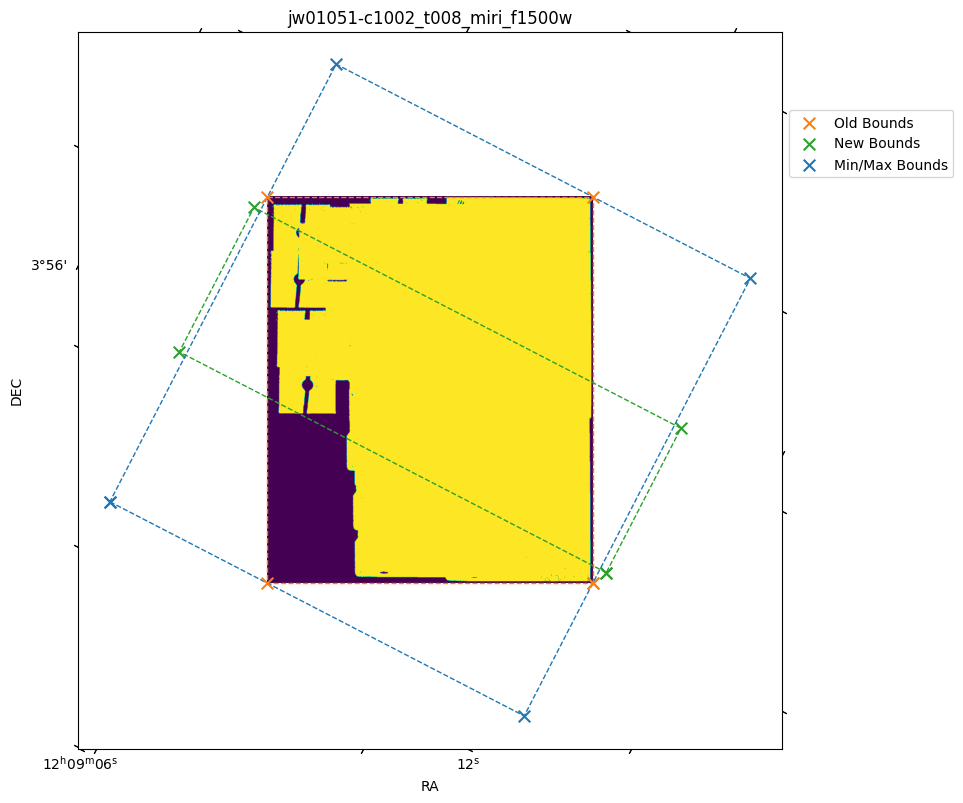

  2%|▏         | 1/48 [01:00<47:24, 60.52s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1481                                                  NAXIS2  =                 1759                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =    59730.61281499398 / [d] exposure start time in MJD                 MJD-AVG =   59730.694530008936 / [d] exposure mid-point in MJD                  MJD-END =   59730.778904224535 / [d] exposure end time in MJD                   TDB-BEG =   59730.615727653414 / [d] TDB time of exposure start in MJD          TDB-MID =   59730.697435176335 / [d] TDB

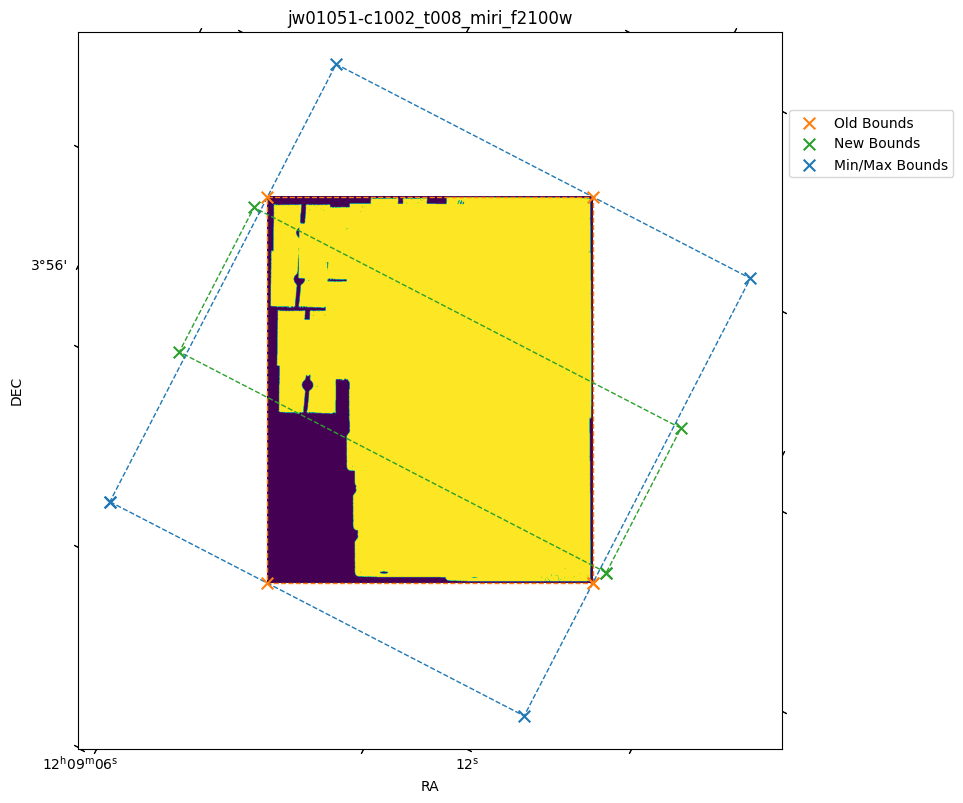

  4%|▍         | 2/48 [01:55<43:48, 57.15s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1481                                                  NAXIS2  =                 1759                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =    59730.61837188287 / [d] exposure start time in MJD                 MJD-AVG =   59730.700353164815 / [d] exposure mid-point in MJD                  MJD-END =   59730.786162743054 / [d] exposure end time in MJD                   TDB-BEG =      59730.621284033 / [d] TDB time of exposure start in MJD          TDB-MID =    59730.70325779821 / [d] TDB

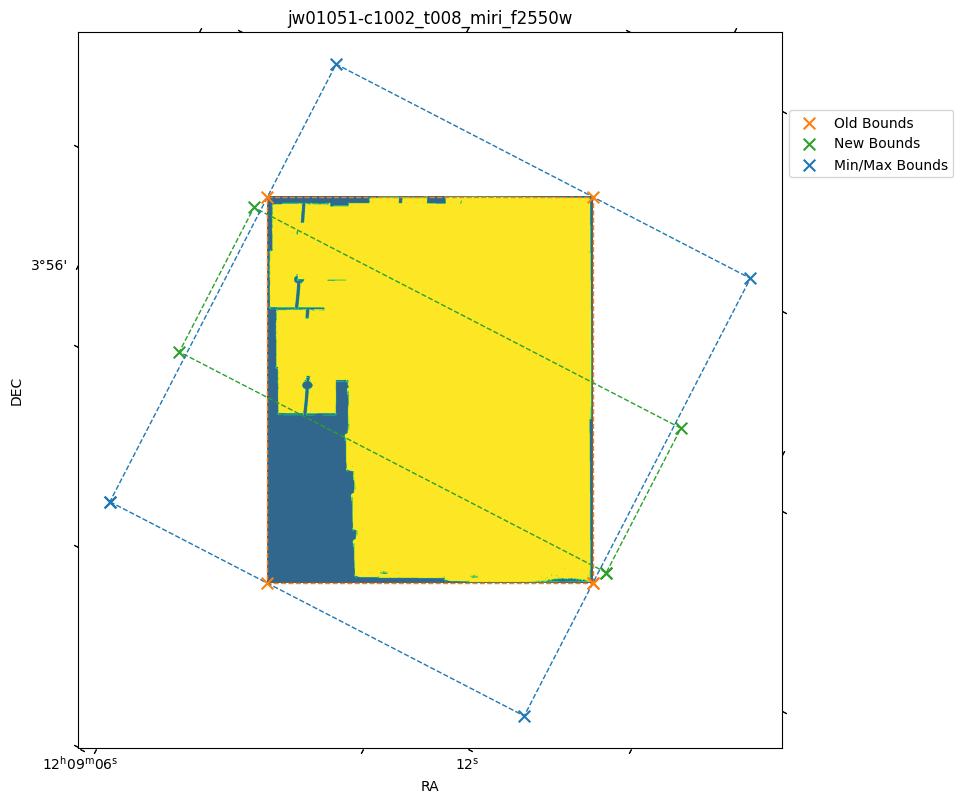

  6%|▋         | 3/48 [02:58<45:01, 60.03s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1190                                                  NAXIS2  =                 1104                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =   59723.523730448615 / [d] exposure start time in MJD                 MJD-AVG =     59723.5261875449 / [d] exposure mid-point in MJD                  MJD-END =    59723.52867649306 / [d] exposure end time in MJD                   TDB-BEG =    59723.52727710776 / [d] TDB time of exposure start in MJD          TDB-MID =    59723.52973399028 / [d] TDB

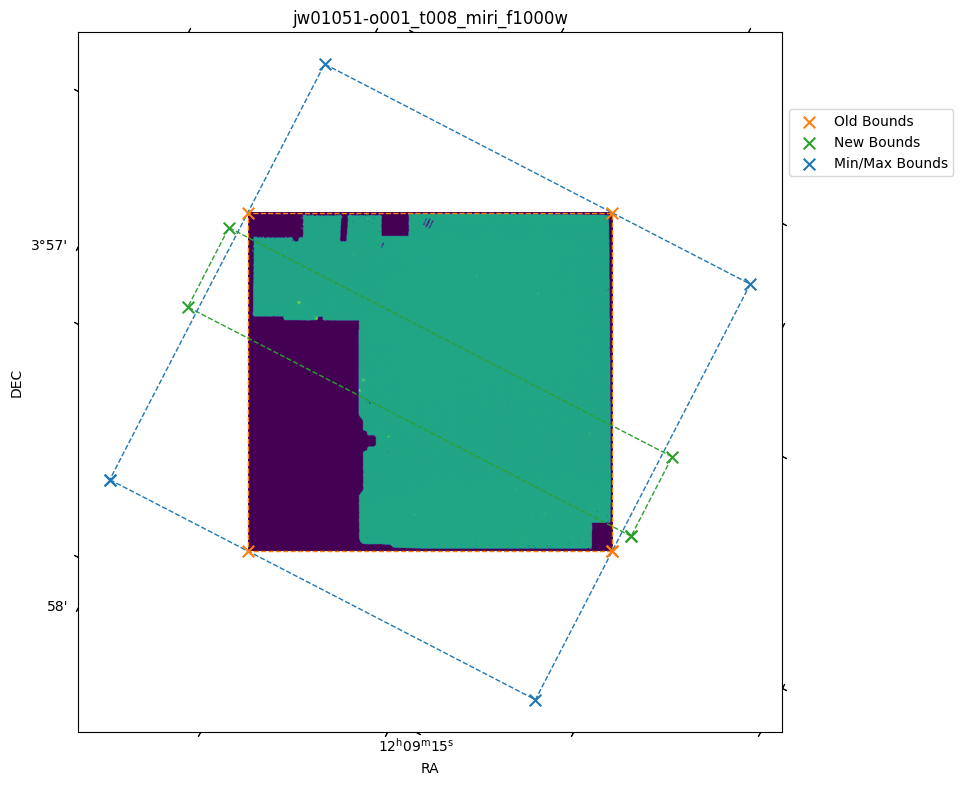

  8%|▊         | 4/48 [03:57<43:33, 59.39s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1190                                                  NAXIS2  =                 1104                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =     59723.5308929375 / [d] exposure start time in MJD                 MJD-AVG =     59723.5333233534 / [d] exposure mid-point in MJD                  MJD-END =         59723.535775 / [d] exposure end time in MJD                   TDB-BEG =    59723.53443897348 / [d] TDB time of exposure start in MJD          TDB-MID =    59723.53686917791 / [d] TDB

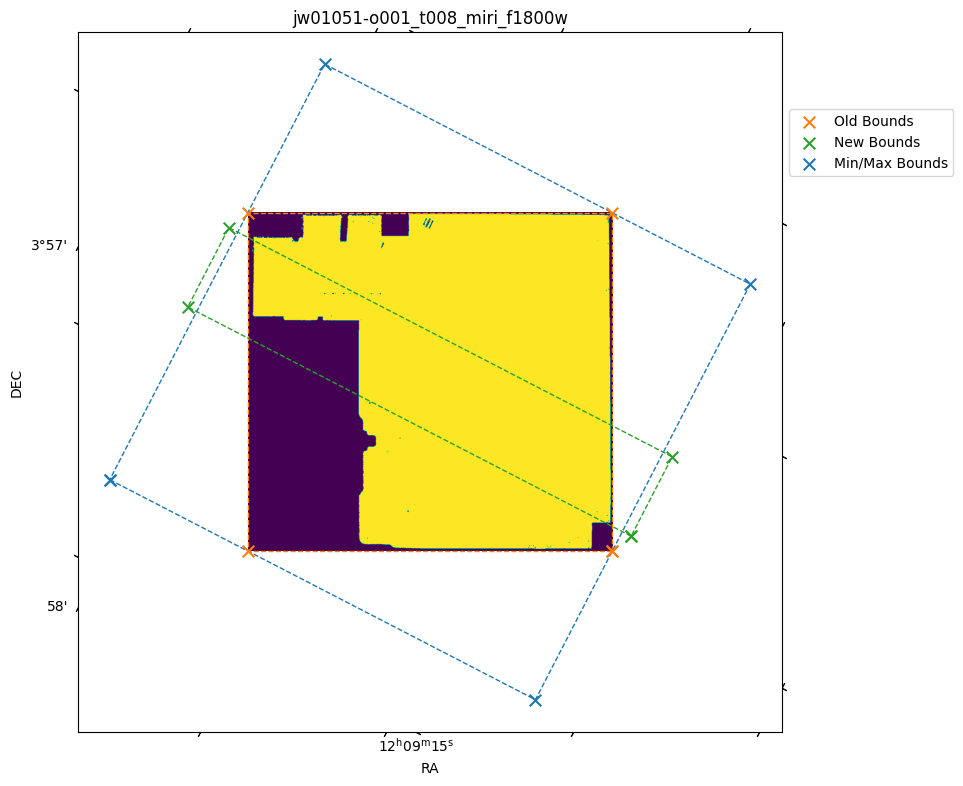

 10%|█         | 5/48 [04:43<39:10, 54.67s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1190                                                  NAXIS2  =                 1104                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =    59723.51325970463 / [d] exposure start time in MJD                 MJD-AVG =    59723.51723711697 / [d] exposure mid-point in MJD                  MJD-END =    59723.52122539352 / [d] exposure end time in MJD                   TDB-BEG =     59723.5168072747 / [d] TDB time of exposure start in MJD          TDB-MID =    59723.52078434103 / [d] TDB

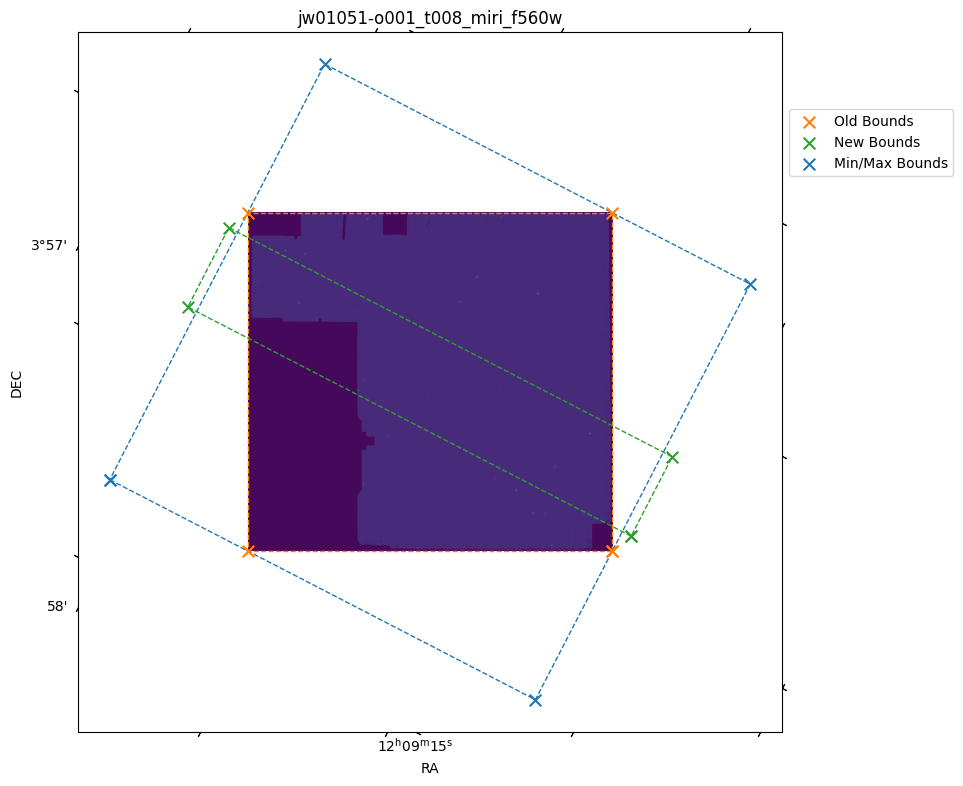

 12%|█▎        | 6/48 [05:46<40:20, 57.63s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1239                                                  NAXIS2  =                 1156                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =    59723.57152373565 / [d] exposure start time in MJD                 MJD-AVG =    59723.57398083195 / [d] exposure mid-point in MJD                  MJD-END =    59723.57643792824 / [d] exposure end time in MJD                   TDB-BEG =   59723.575066235884 / [d] TDB time of exposure start in MJD          TDB-MID =    59723.57752311832 / [d] TDB

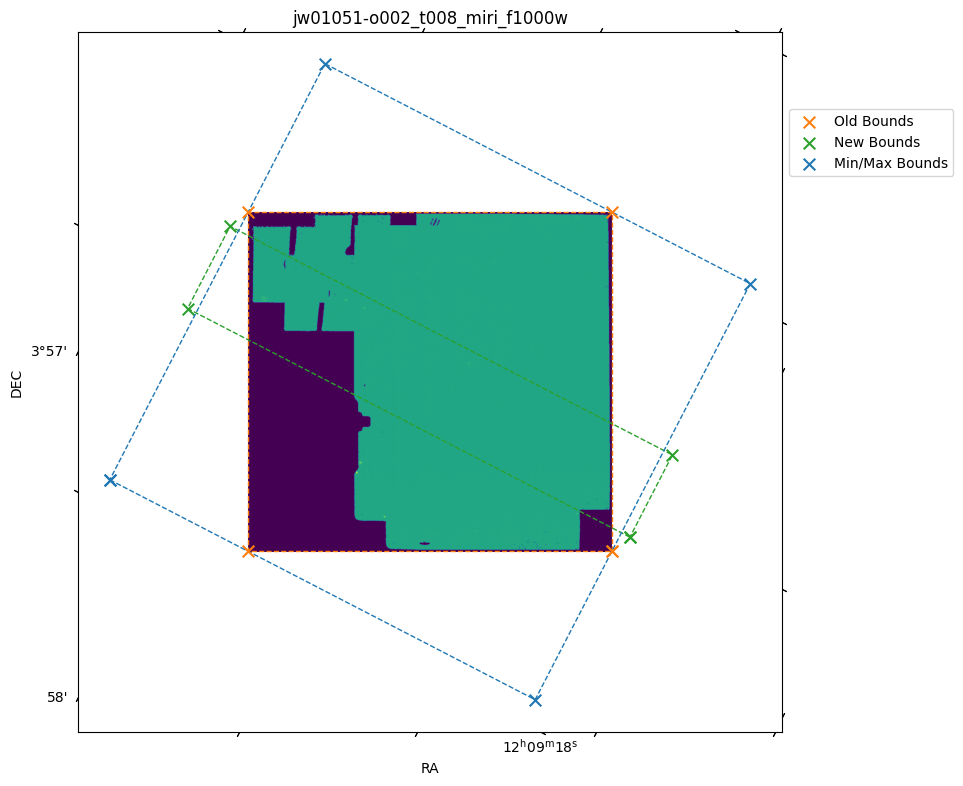

 15%|█▍        | 7/48 [06:48<40:11, 58.83s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1239                                                  NAXIS2  =                 1156                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =   59723.578815113426 / [d] exposure start time in MJD                 MJD-AVG =    59723.58123491204 / [d] exposure mid-point in MJD                  MJD-END =    59723.58366532408 / [d] exposure end time in MJD                   TDB-BEG =    59723.58235697903 / [d] TDB time of exposure start in MJD          TDB-MID =   59723.584776567004 / [d] TDB

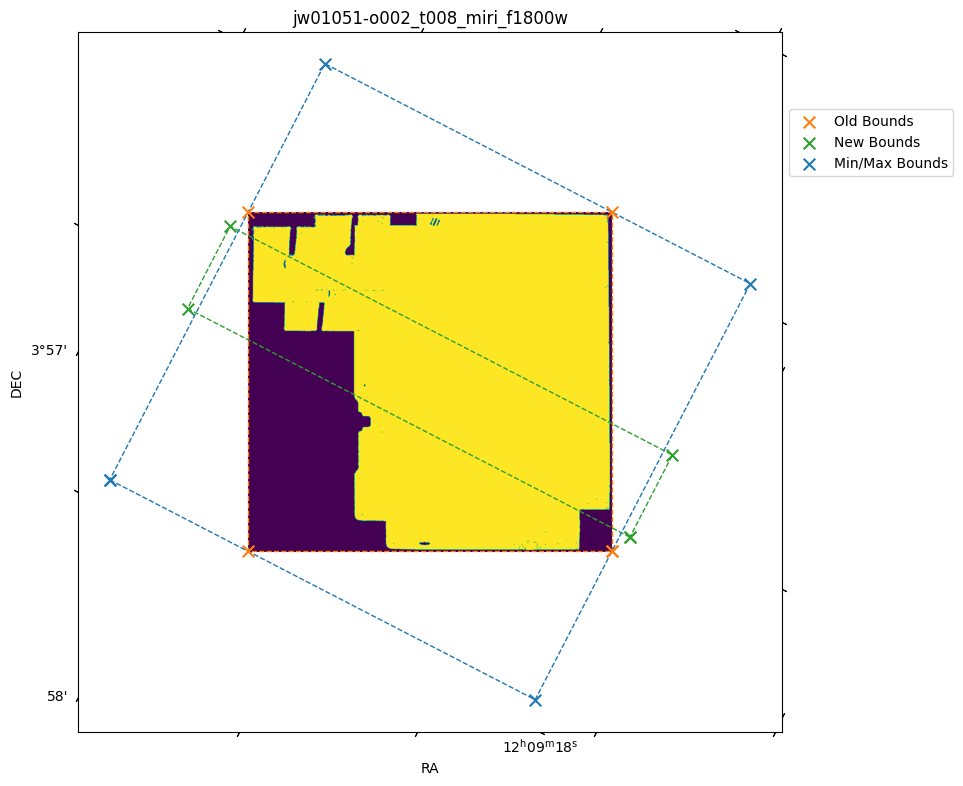

 17%|█▋        | 8/48 [07:30<35:43, 53.60s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1239                                                  NAXIS2  =                 1156                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =    59723.56095669537 / [d] exposure start time in MJD                 MJD-AVG =    59723.56497707069 / [d] exposure mid-point in MJD                  MJD-END =     59723.5689868287 / [d] exposure end time in MJD                   TDB-BEG =    59723.56450011528 / [d] TDB time of exposure start in MJD          TDB-MID =   59723.568520140696 / [d] TDB

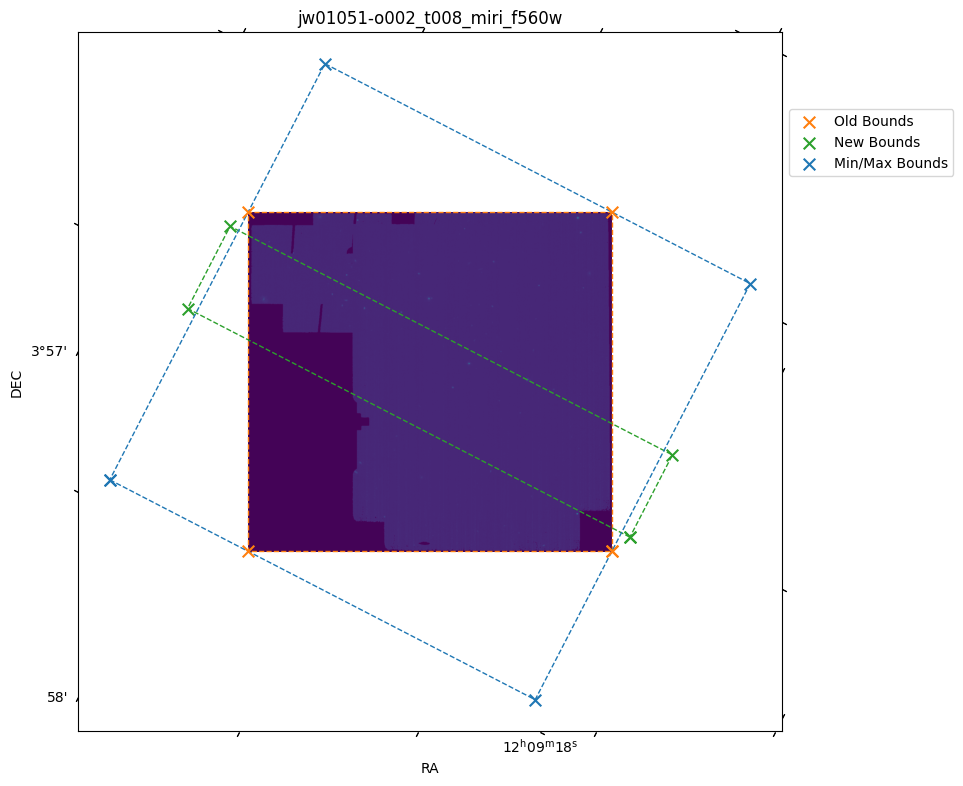

 19%|█▉        | 9/48 [08:35<37:14, 57.29s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1156                                                  NAXIS2  =                 1230                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =   59723.617775541206 / [d] exposure start time in MJD                 MJD-AVG =   59723.620264983176 / [d] exposure mid-point in MJD                  MJD-END =    59723.62275417824 / [d] exposure end time in MJD                   TDB-BEG =    59723.62131401505 / [d] TDB time of exposure start in MJD          TDB-MID =    59723.62380324027 / [d] TDB

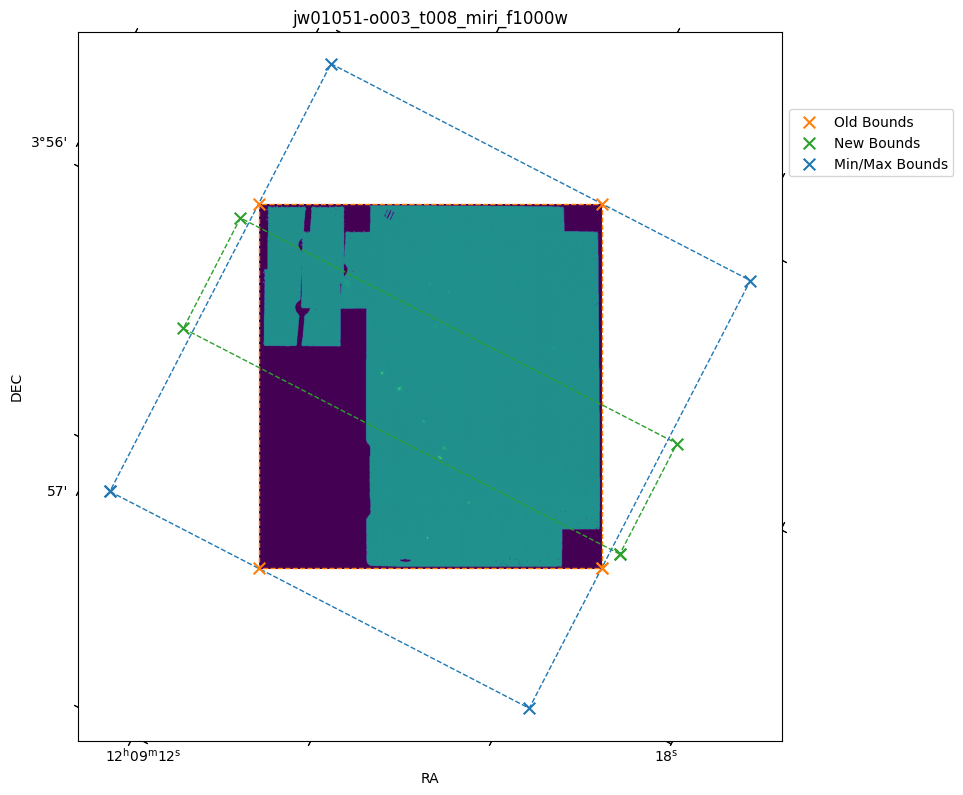

 21%|██        | 10/48 [09:38<37:14, 58.80s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1156                                                  NAXIS2  =                 1230                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =    59723.62500247454 / [d] exposure start time in MJD                 MJD-AVG =    59723.62743289429 / [d] exposure mid-point in MJD                  MJD-END =    59723.62985269676 / [d] exposure end time in MJD                   TDB-BEG =   59723.628540319114 / [d] TDB time of exposure start in MJD          TDB-MID =    59723.63097052722 / [d] TDB

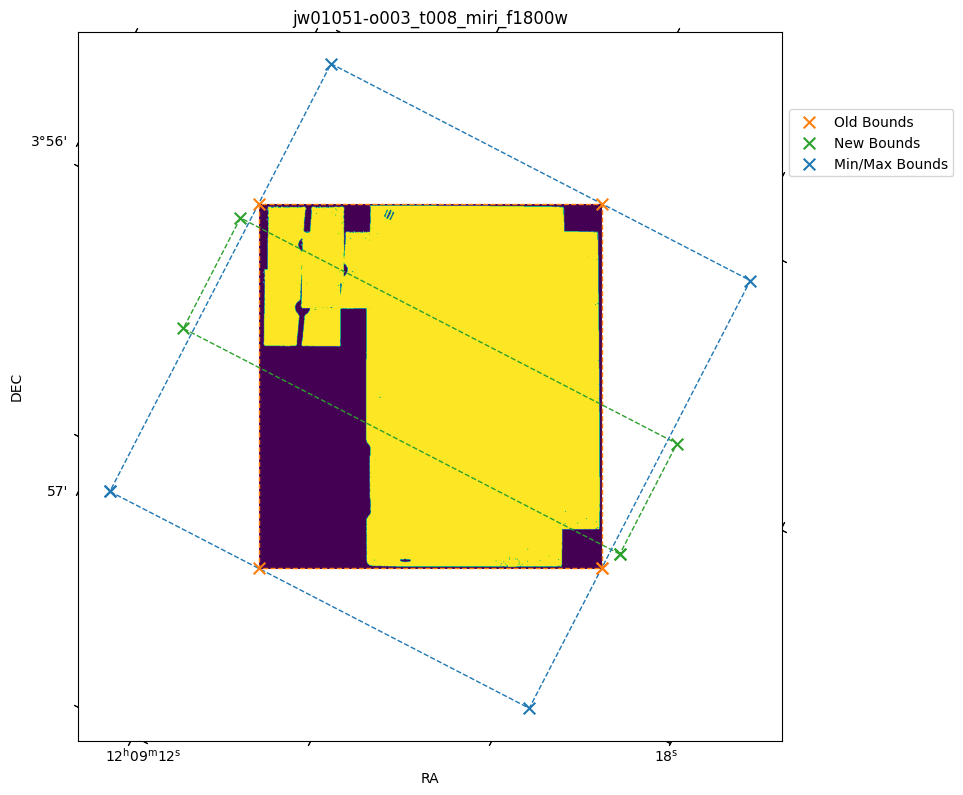

 23%|██▎       | 11/48 [10:26<34:16, 55.59s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1156                                                  NAXIS2  =                 1230                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =   59723.607144056485 / [d] exposure start time in MJD                 MJD-AVG =   59723.611185666356 / [d] exposure mid-point in MJD                  MJD-END =    59723.61523789352 / [d] exposure end time in MJD                   TDB-BEG =    59723.61068345598 / [d] TDB time of exposure start in MJD          TDB-MID =    59723.61472471398 / [d] TDB

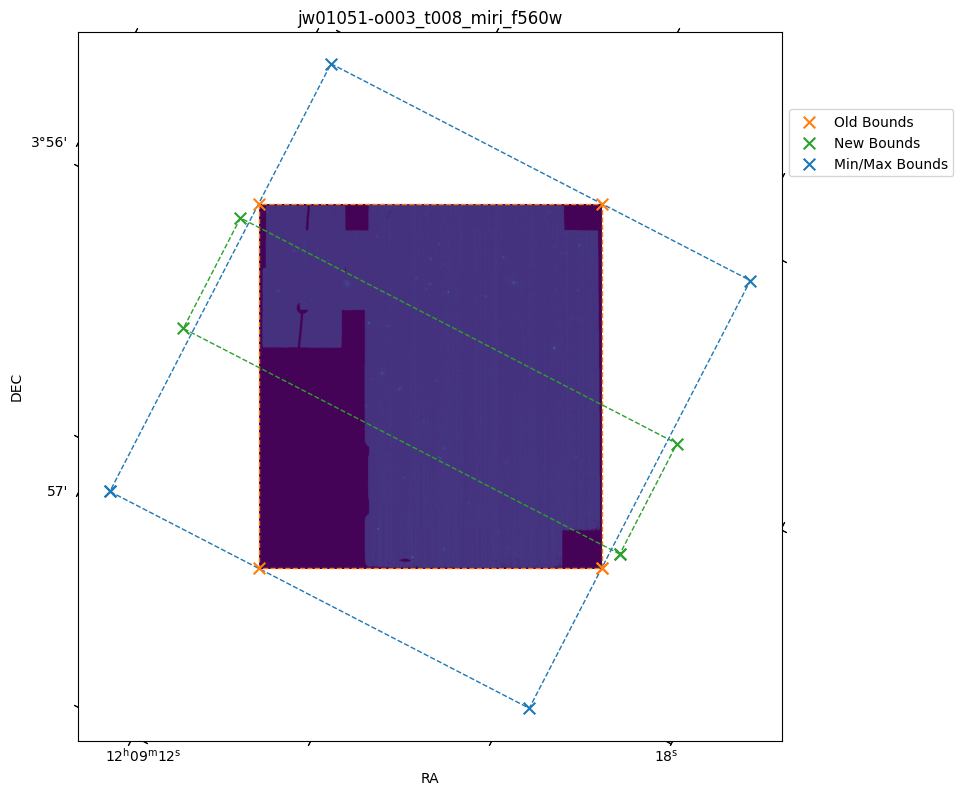

 25%|██▌       | 12/48 [11:19<32:52, 54.79s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1080                                                  NAXIS2  =                 1230                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =   59723.666404383795 / [d] exposure start time in MJD                 MJD-AVG =    59723.66889357886 / [d] exposure mid-point in MJD                  MJD-END =    59723.67138302083 / [d] exposure end time in MJD                   TDB-BEG =    59723.66993862261 / [d] TDB time of exposure start in MJD          TDB-MID =    59723.67242760084 / [d] TDB

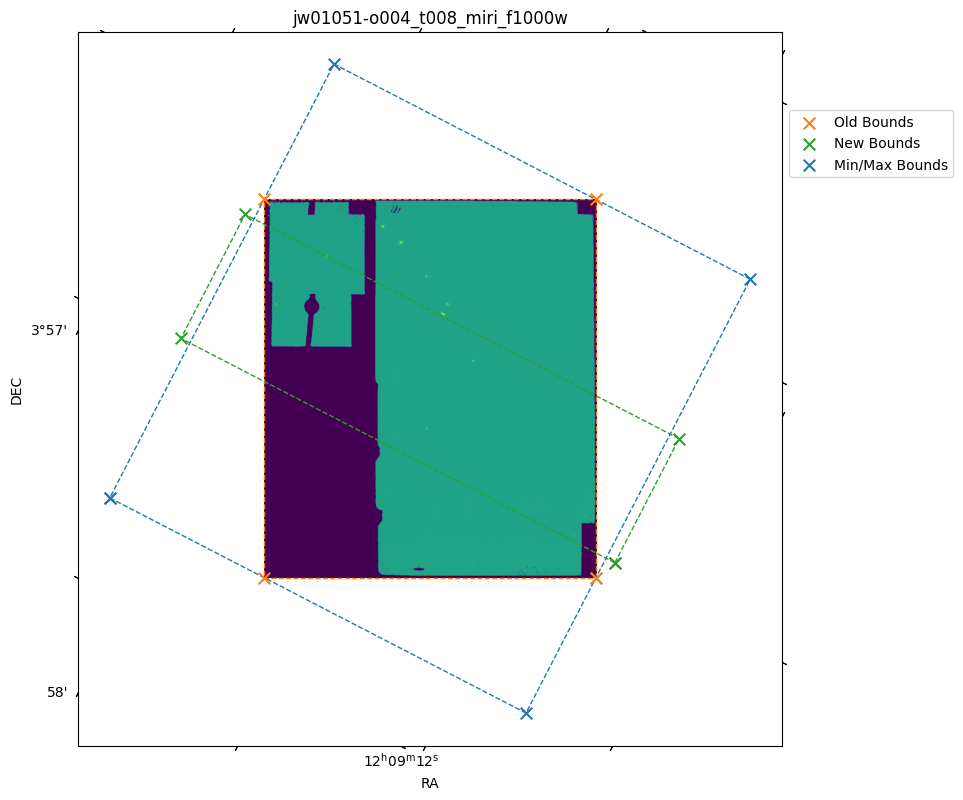

 27%|██▋       | 13/48 [12:08<30:54, 52.99s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1080                                                  NAXIS2  =                 1230                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =   59723.673598724534 / [d] exposure start time in MJD                 MJD-AVG =   59723.676200498456 / [d] exposure mid-point in MJD                  MJD-END =    59723.67873782408 / [d] exposure end time in MJD                   TDB-BEG =    59723.67713233665 / [d] TDB time of exposure start in MJD          TDB-MID =    59723.67973388392 / [d] TDB

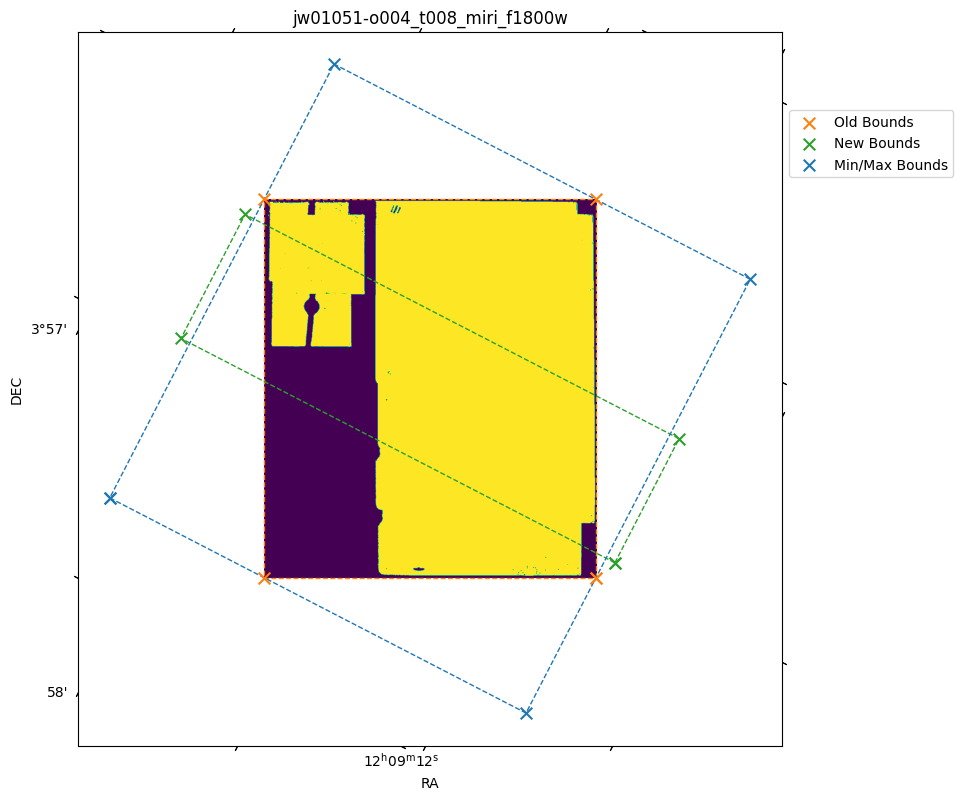

 29%|██▉       | 14/48 [12:52<28:31, 50.35s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1080                                                  NAXIS2  =                 1230                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =   59723.655644010185 / [d] exposure start time in MJD                 MJD-AVG =   59723.659707348466 / [d] exposure mid-point in MJD                  MJD-END =   59723.663738587966 / [d] exposure end time in MJD                   TDB-BEG =    59723.65917918626 / [d] TDB time of exposure start in MJD          TDB-MID =    59723.66324217061 / [d] TDB

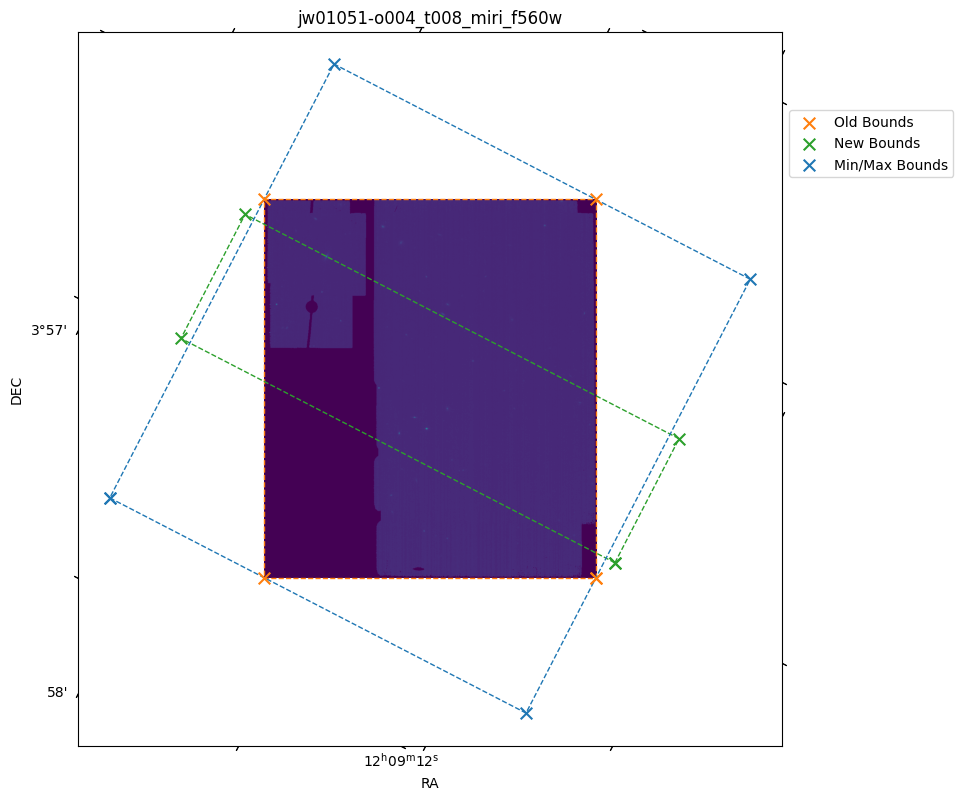

 31%|███▏      | 15/48 [13:51<29:03, 52.82s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1236                                                  NAXIS2  =                 1189                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =    59723.71519322639 / [d] exposure start time in MJD                 MJD-AVG =   59723.719117236265 / [d] exposure mid-point in MJD                  MJD-END =    59723.72229186343 / [d] exposure end time in MJD                   TDB-BEG =   59723.718723214464 / [d] TDB time of exposure start in MJD          TDB-MID =    59723.72264688238 / [d] TDB

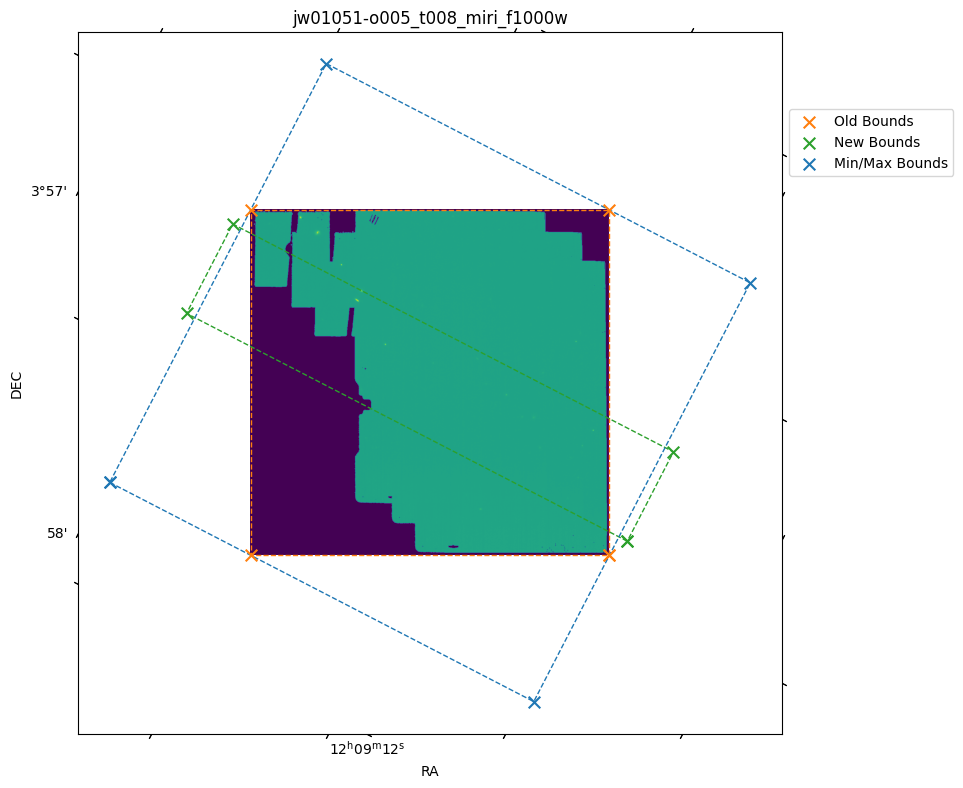

 33%|███▎      | 16/48 [14:30<26:03, 48.87s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1236                                                  NAXIS2  =                 1189                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =     59723.7245082963 / [d] exposure start time in MJD                 MJD-AVG =   59723.728426864196 / [d] exposure mid-point in MJD                  MJD-END =    59723.73160666667 / [d] exposure end time in MJD                   TDB-BEG =   59723.728037472596 / [d] TDB time of exposure start in MJD          TDB-MID =    59723.73195569898 / [d] TDB

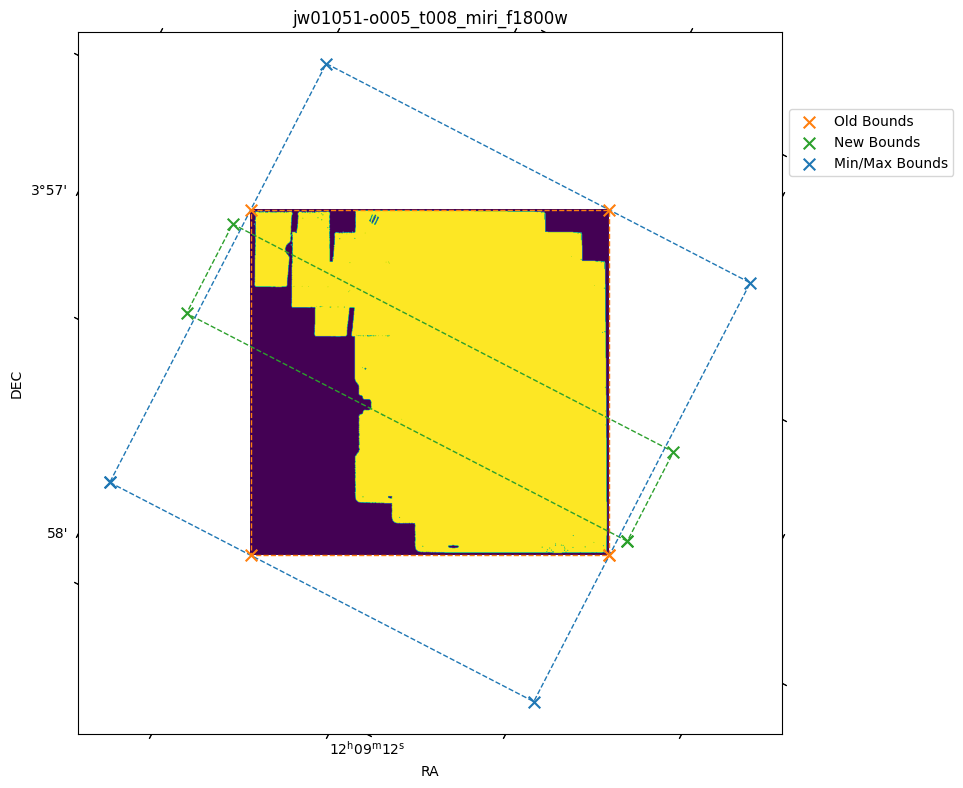

 35%|███▌      | 17/48 [15:10<23:52, 46.21s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1236                                                  NAXIS2  =                 1189                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =    59723.70247433426 / [d] exposure start time in MJD                 MJD-AVG =   59723.707961129316 / [d] exposure mid-point in MJD                  MJD-END =    59723.71272002315 / [d] exposure end time in MJD                   TDB-BEG =    59723.70600543064 / [d] TDB time of exposure start in MJD          TDB-MID =    59723.71149174761 / [d] TDB

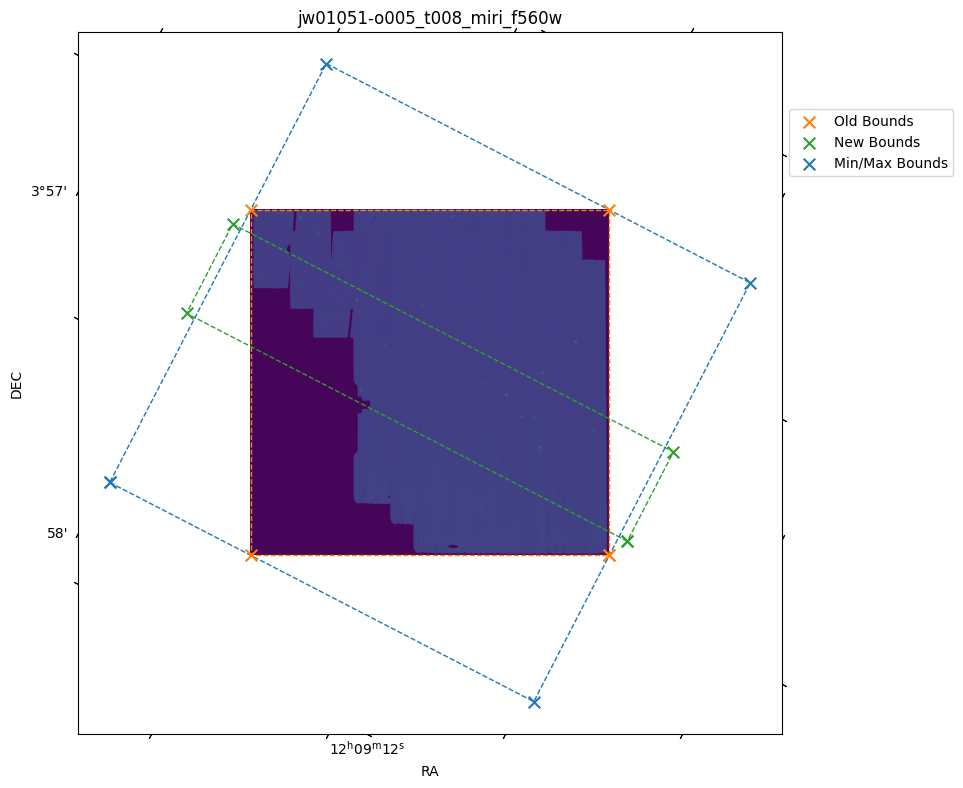

 38%|███▊      | 18/48 [15:51<22:19, 44.65s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1190                                                  NAXIS2  =                 1104                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =    59726.18083686528 / [d] exposure start time in MJD                 MJD-AVG =   59726.187641019445 / [d] exposure mid-point in MJD                  MJD-END =    59726.19445578704 / [d] exposure end time in MJD                   TDB-BEG =    59726.18414979833 / [d] TDB time of exposure start in MJD          TDB-MID =    59726.19095334763 / [d] TDB

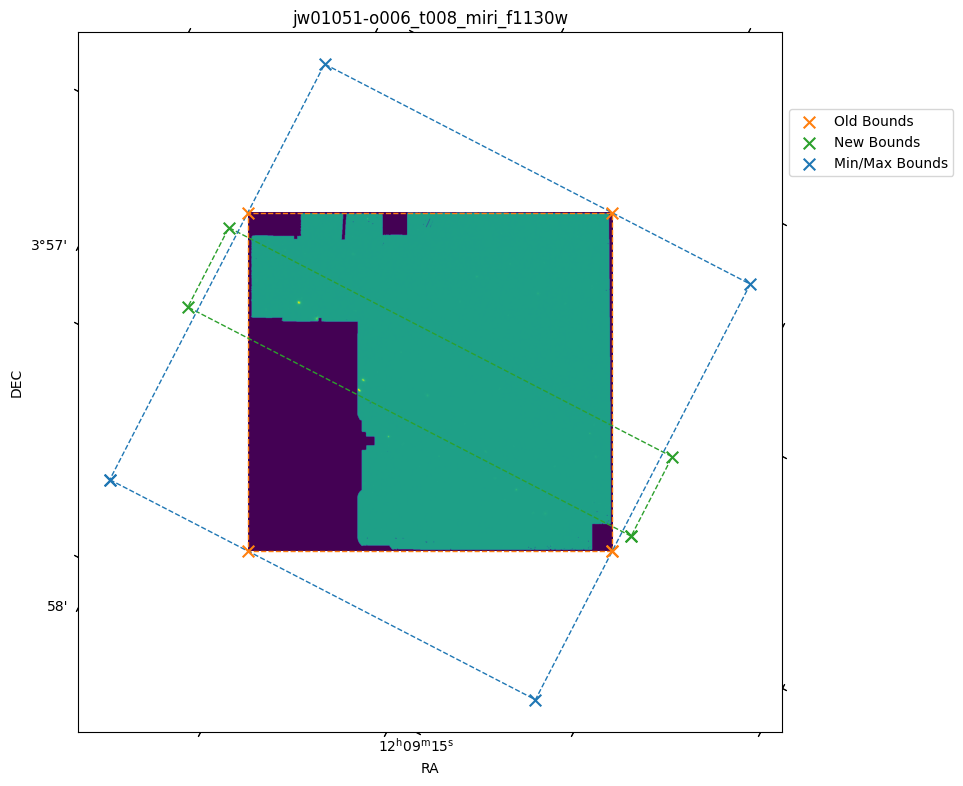

 40%|███▉      | 19/48 [16:33<21:06, 43.67s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1190                                                  NAXIS2  =                 1104                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =   59726.196382601855 / [d] exposure start time in MJD                 MJD-AVG =    59726.19883450309 / [d] exposure mid-point in MJD                  MJD-END =    59726.20129726852 / [d] exposure end time in MJD                   TDB-BEG =    59726.19969415289 / [d] TDB time of exposure start in MJD          TDB-MID =   59726.202145836134 / [d] TDB

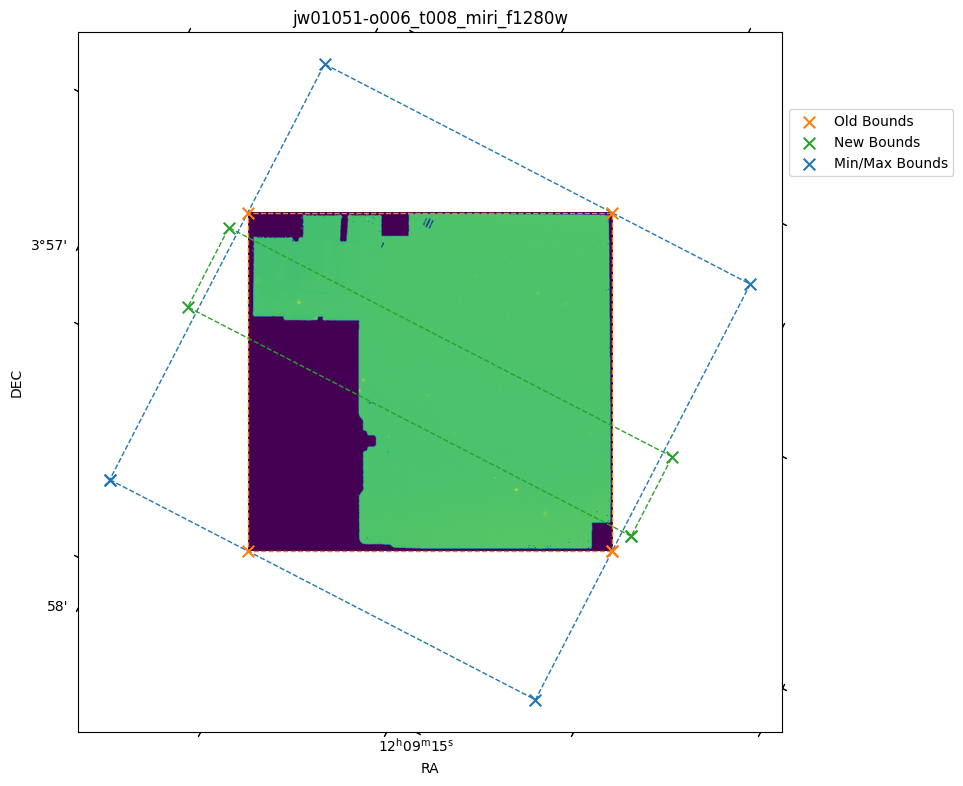

 42%|████▏     | 20/48 [17:17<20:26, 43.79s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1190                                                  NAXIS2  =                 1104                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =    59726.17303172129 / [d] exposure start time in MJD                 MJD-AVG =    59726.17554808288 / [d] exposure mid-point in MJD                  MJD-END =    59726.17807505787 / [d] exposure end time in MJD                   TDB-BEG =    59726.17634534816 / [d] TDB time of exposure start in MJD          TDB-MID =   59726.178861486056 / [d] TDB

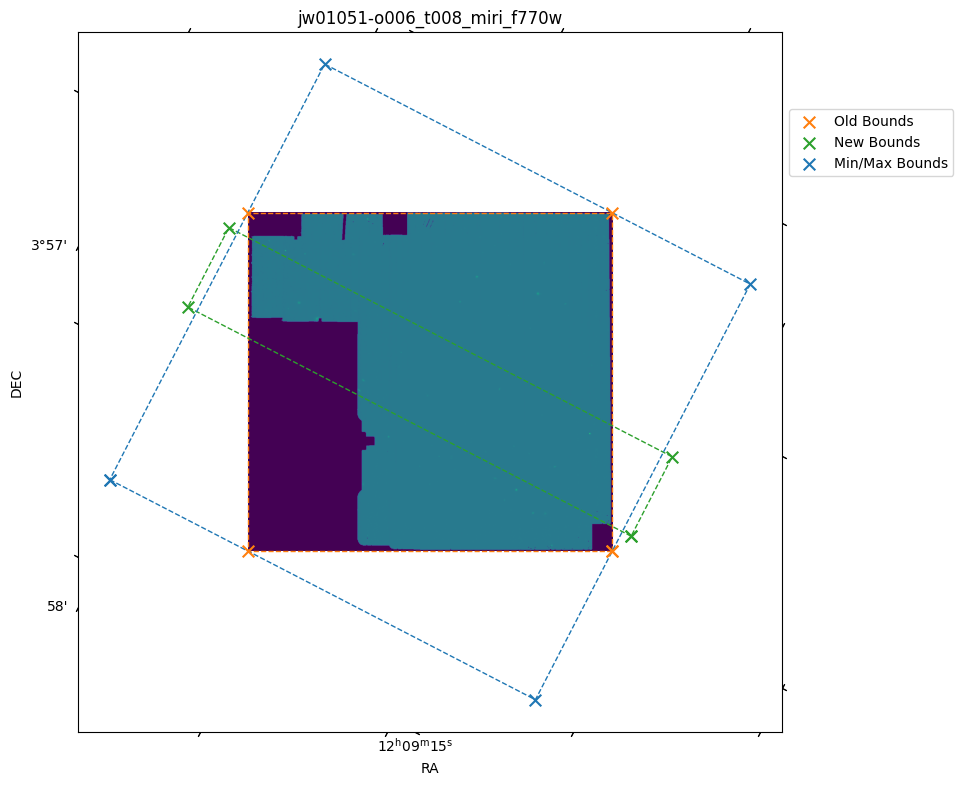

 44%|████▍     | 21/48 [18:12<21:17, 47.30s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1239                                                  NAXIS2  =                 1156                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =    59726.23887680741 / [d] exposure start time in MJD                 MJD-AVG =    59726.24568046775 / [d] exposure mid-point in MJD                  MJD-END =   59726.252494988425 / [d] exposure end time in MJD                   TDB-BEG =    59726.24218457988 / [d] TDB time of exposure start in MJD          TDB-MID =   59726.248987635125 / [d] TDB

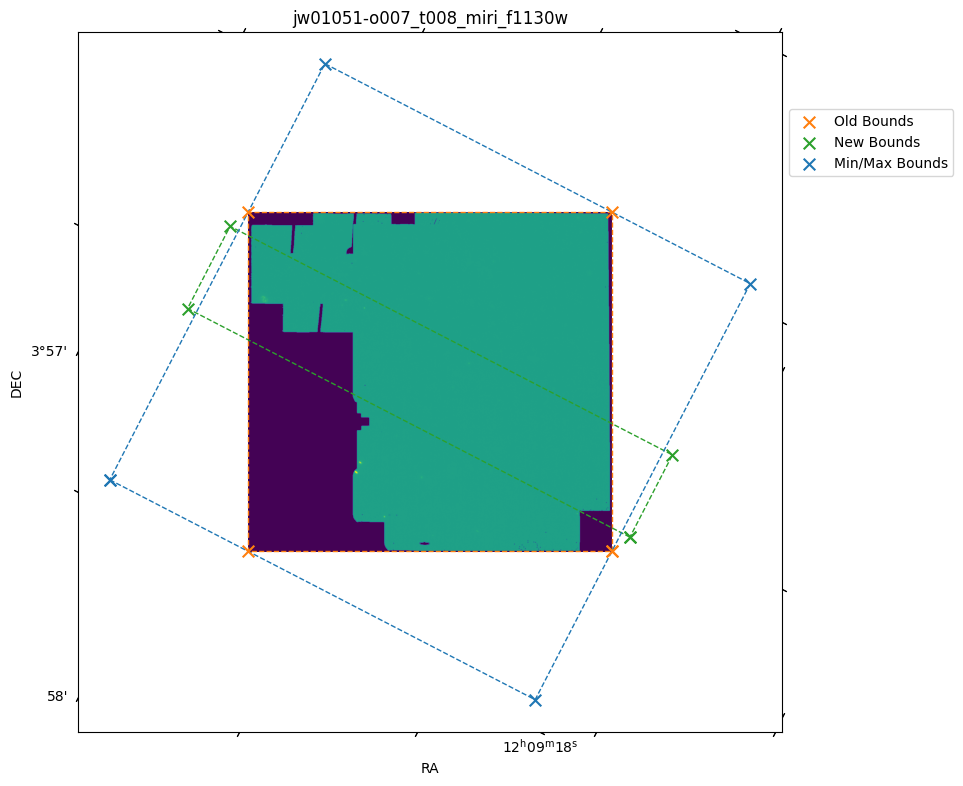

 46%|████▌     | 22/48 [18:56<20:03, 46.28s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1239                                                  NAXIS2  =                 1156                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =   59726.254486247686 / [d] exposure start time in MJD                 MJD-AVG =    59726.25693814892 / [d] exposure mid-point in MJD                  MJD-END =    59726.25936832176 / [d] exposure end time in MJD                   TDB-BEG =    59726.25779263187 / [d] TDB time of exposure start in MJD          TDB-MID =    59726.26024431502 / [d] TDB

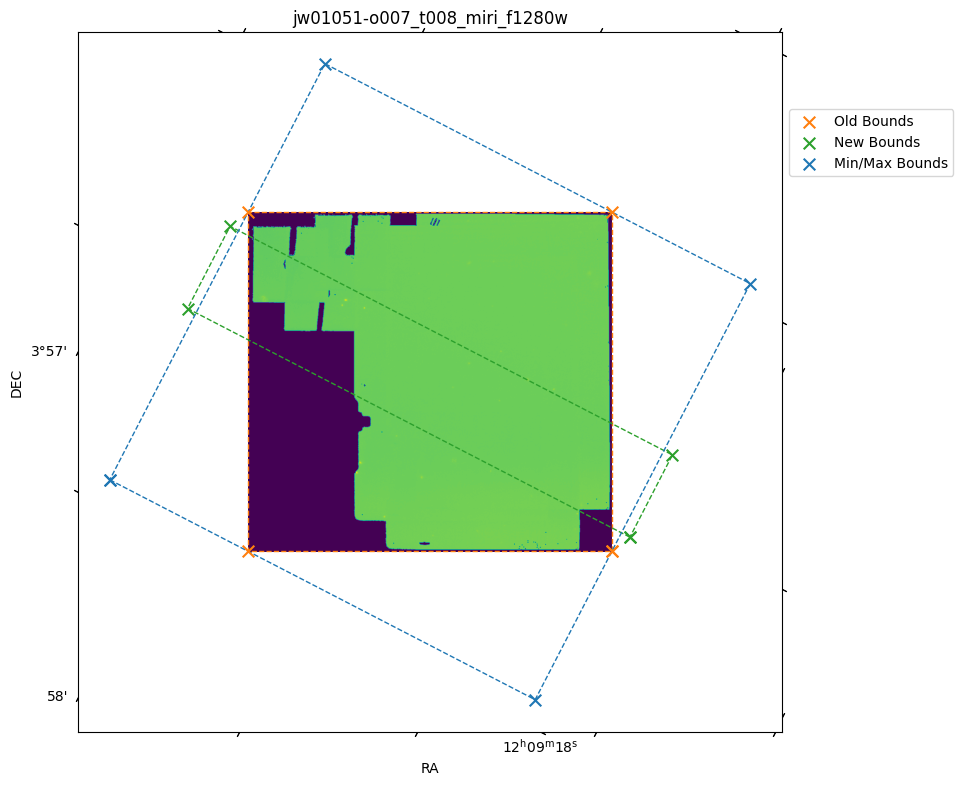

 48%|████▊     | 23/48 [19:37<18:37, 44.69s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1239                                                  NAXIS2  =                 1156                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =   59726.231103515274 / [d] exposure start time in MJD                 MJD-AVG =    59726.23363025108 / [d] exposure mid-point in MJD                  MJD-END =    59726.23614612268 / [d] exposure end time in MJD                   TDB-BEG =   59726.234411979036 / [d] TDB time of exposure start in MJD          TDB-MID =    59726.23693849015 / [d] TDB

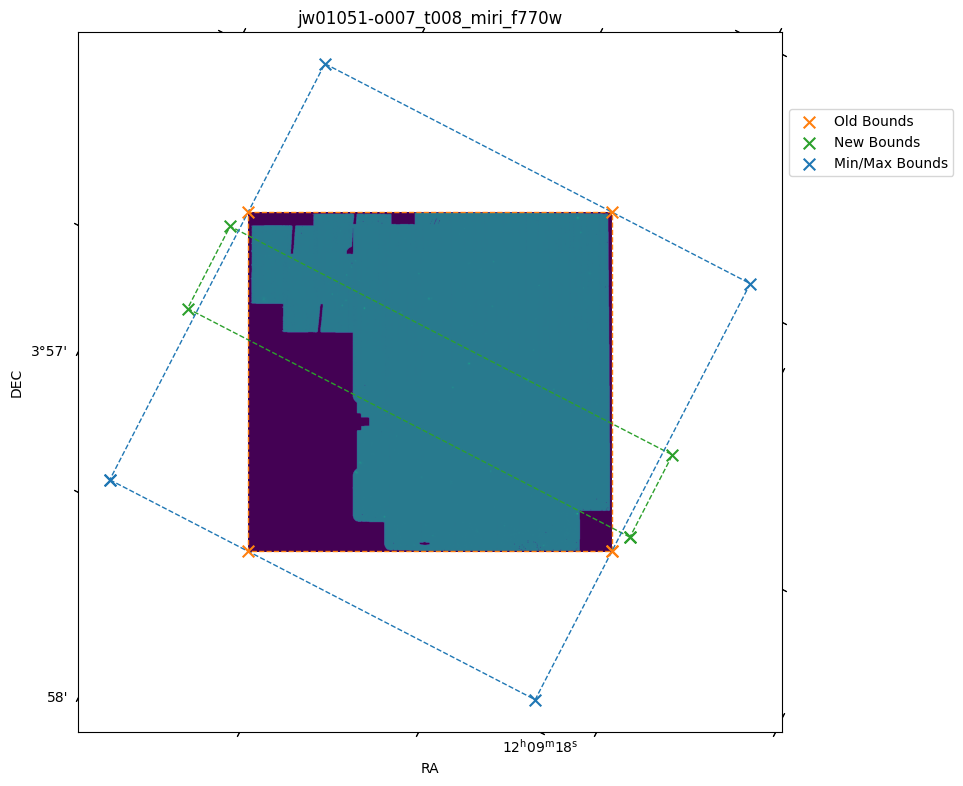

 50%|█████     | 24/48 [20:48<21:01, 52.57s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1156                                                  NAXIS2  =                 1230                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =    59726.29540637917 / [d] exposure start time in MJD                 MJD-AVG =   59726.302263866666 / [d] exposure mid-point in MJD                  MJD-END =    59726.30912159722 / [d] exposure end time in MJD                   TDB-BEG =    59726.29870912316 / [d] TDB time of exposure start in MJD          TDB-MID =    59726.30556600052 / [d] TDB

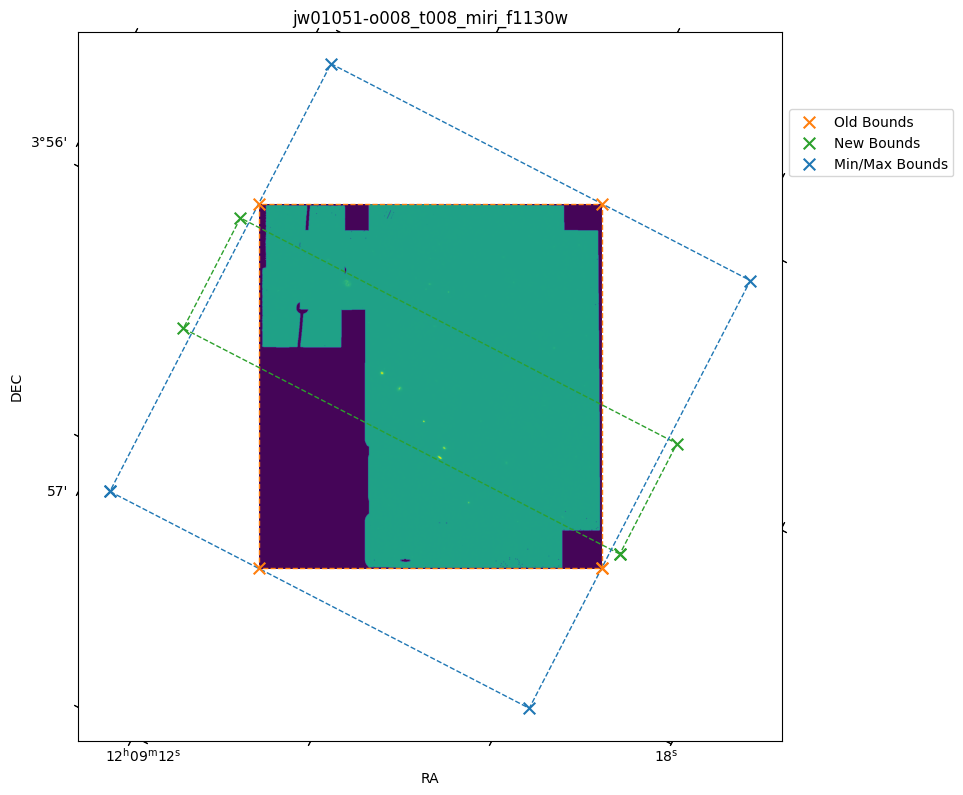

 52%|█████▏    | 25/48 [22:01<22:30, 58.71s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1156                                                  NAXIS2  =                 1230                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =    59726.31098396759 / [d] exposure start time in MJD                 MJD-AVG =   59726.313457350305 / [d] exposure mid-point in MJD                  MJD-END =    59726.31593048611 / [d] exposure end time in MJD                   TDB-BEG =   59726.314285325534 / [d] TDB time of exposure start in MJD          TDB-MID =    59726.31675848816 / [d] TDB

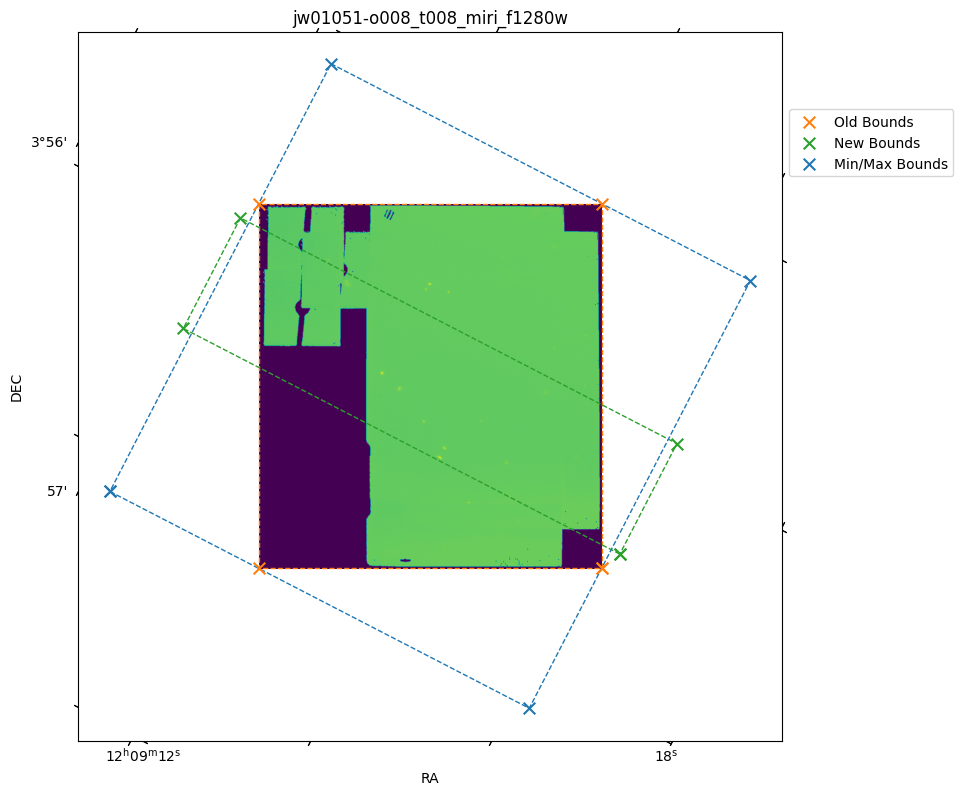

 54%|█████▍    | 26/48 [22:46<19:59, 54.52s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1156                                                  NAXIS2  =                 1230                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =    59726.28763382778 / [d] exposure start time in MJD                 MJD-AVG =    59726.29018179814 / [d] exposure mid-point in MJD                  MJD-END =    59726.29270828704 / [d] exposure end time in MJD                   TDB-BEG =    59726.29093726329 / [d] TDB time of exposure start in MJD          TDB-MID =    59726.29348500698 / [d] TDB

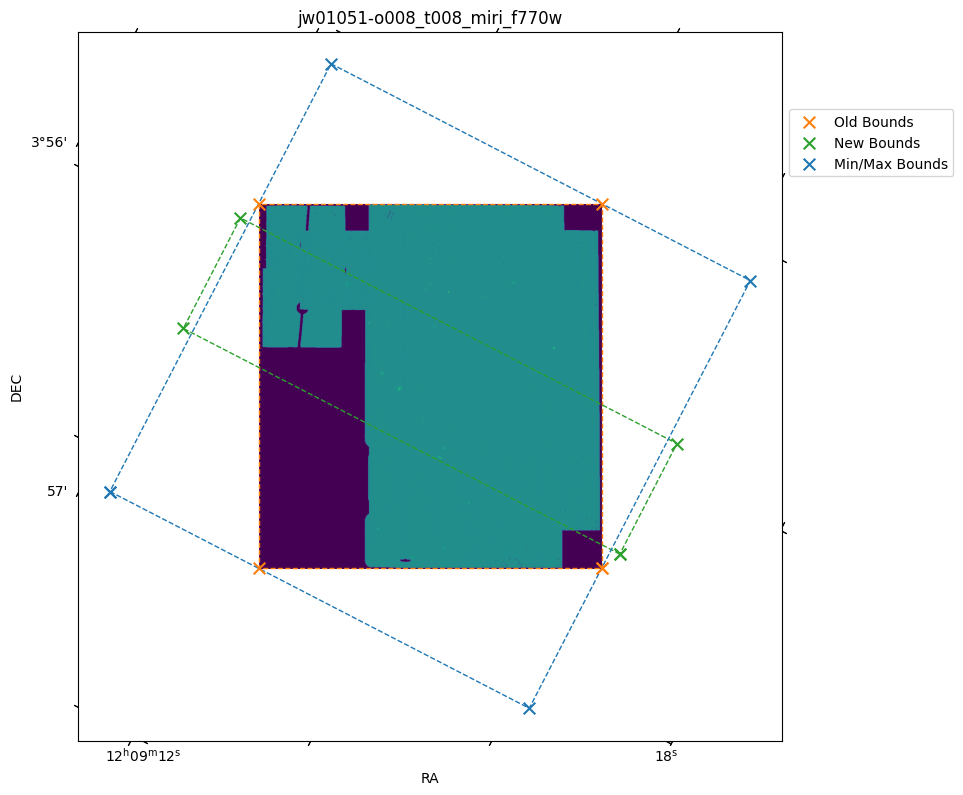

 56%|█████▋    | 27/48 [23:28<17:47, 50.85s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1080                                                  NAXIS2  =                 1229                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =    59726.35408854352 / [d] exposure start time in MJD                 MJD-AVG =    59726.36093517068 / [d] exposure mid-point in MJD                  MJD-END =    59726.36777118056 / [d] exposure end time in MJD                   TDB-BEG =   59726.357386065276 / [d] TDB time of exposure start in MJD          TDB-MID =    59726.36423208299 / [d] TDB

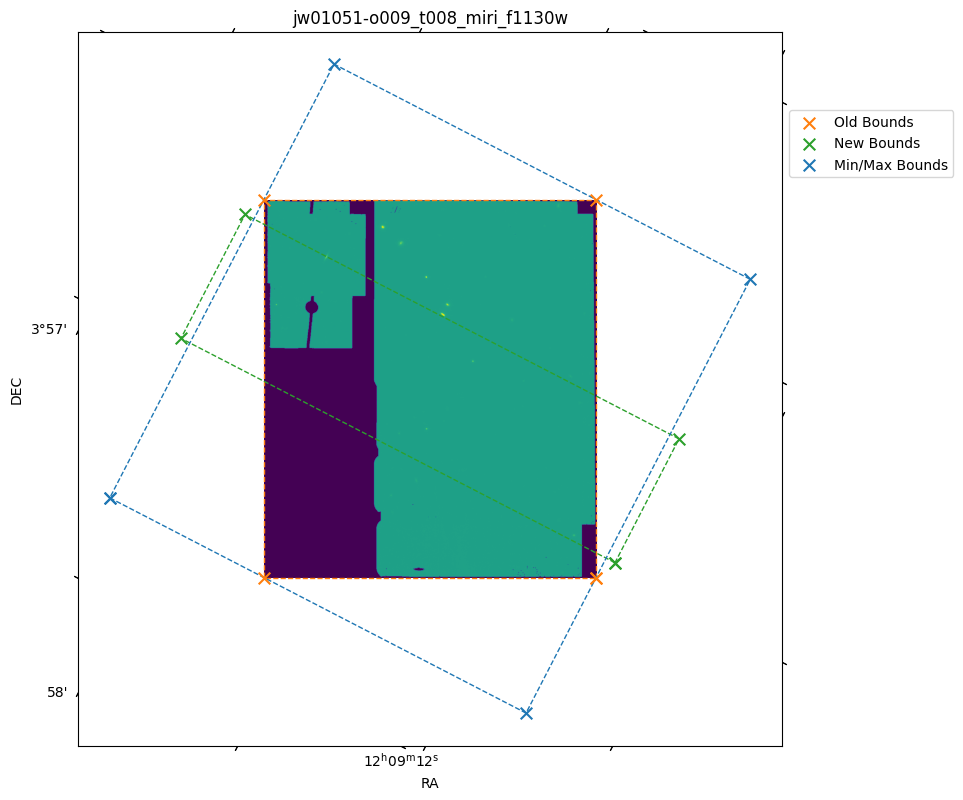

 58%|█████▊    | 28/48 [24:39<18:57, 56.90s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1080                                                  NAXIS2  =                 1229                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =    59726.36963428009 / [d] exposure start time in MJD                 MJD-AVG =    59726.37210716898 / [d] exposure mid-point in MJD                  MJD-END =    59726.37458005787 / [d] exposure end time in MJD                   TDB-BEG =    59726.37293041801 / [d] TDB time of exposure start in MJD          TDB-MID =    59726.37540308675 / [d] TDB

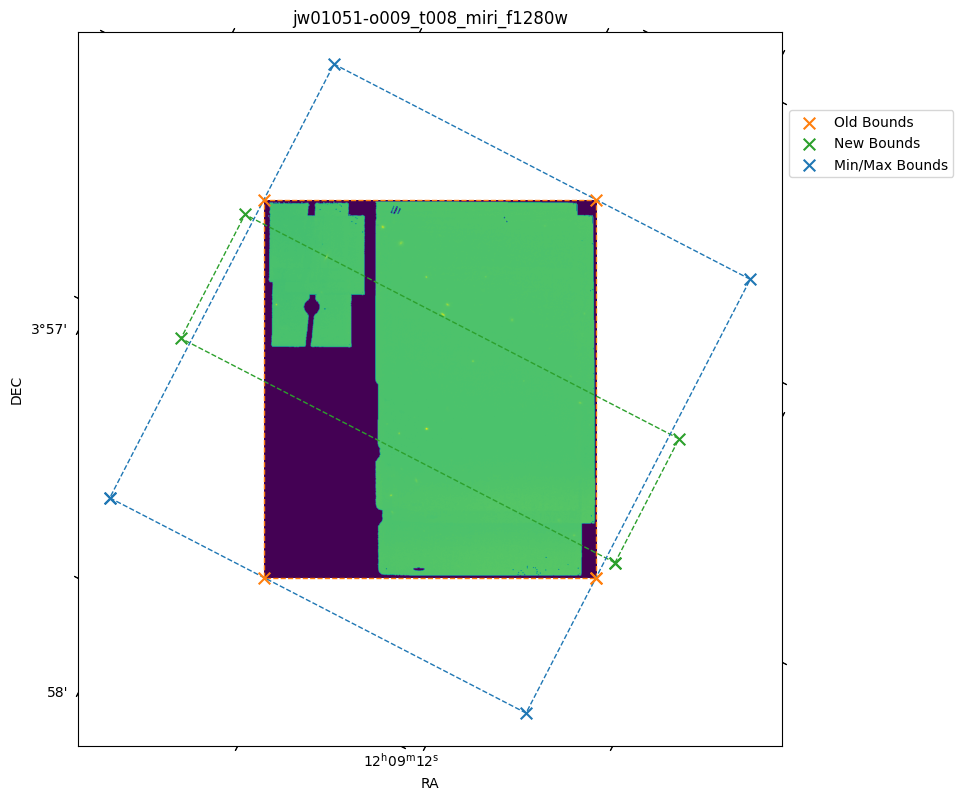

 60%|██████    | 29/48 [25:20<16:30, 52.11s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1080                                                  NAXIS2  =                 1229                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =    59726.34637969583 / [d] exposure start time in MJD                 MJD-AVG =     59726.3489385304 / [d] exposure mid-point in MJD                  MJD-END =   59726.351486747684 / [d] exposure end time in MJD                   TDB-BEG =   59726.349677903745 / [d] TDB time of exposure start in MJD          TDB-MID =    59726.35223651055 / [d] TDB

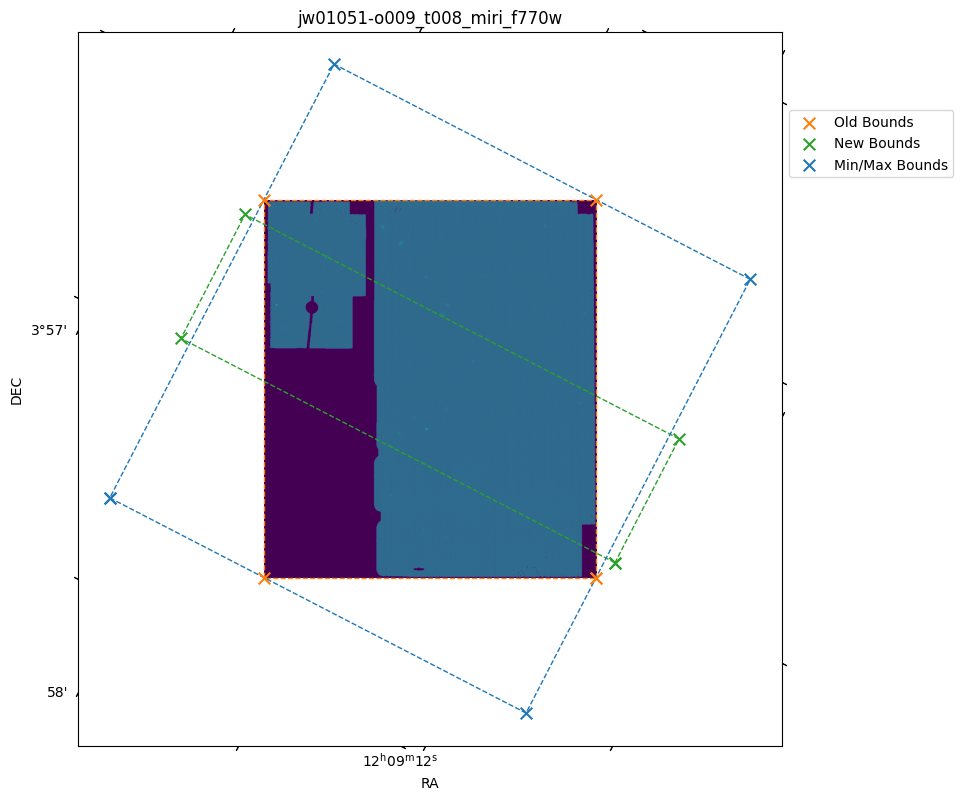

 62%|██████▎   | 30/48 [26:03<14:46, 49.25s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1236                                                  NAXIS2  =                 1189                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =     59726.4155323375 / [d] exposure start time in MJD                 MJD-AVG =     59726.4228609855 / [d] exposure mid-point in MJD                  MJD-END =    59726.42940814815 / [d] exposure end time in MJD                   TDB-BEG =   59726.418824388755 / [d] TDB time of exposure start in MJD          TDB-MID =    59726.42615238408 / [d] TDB

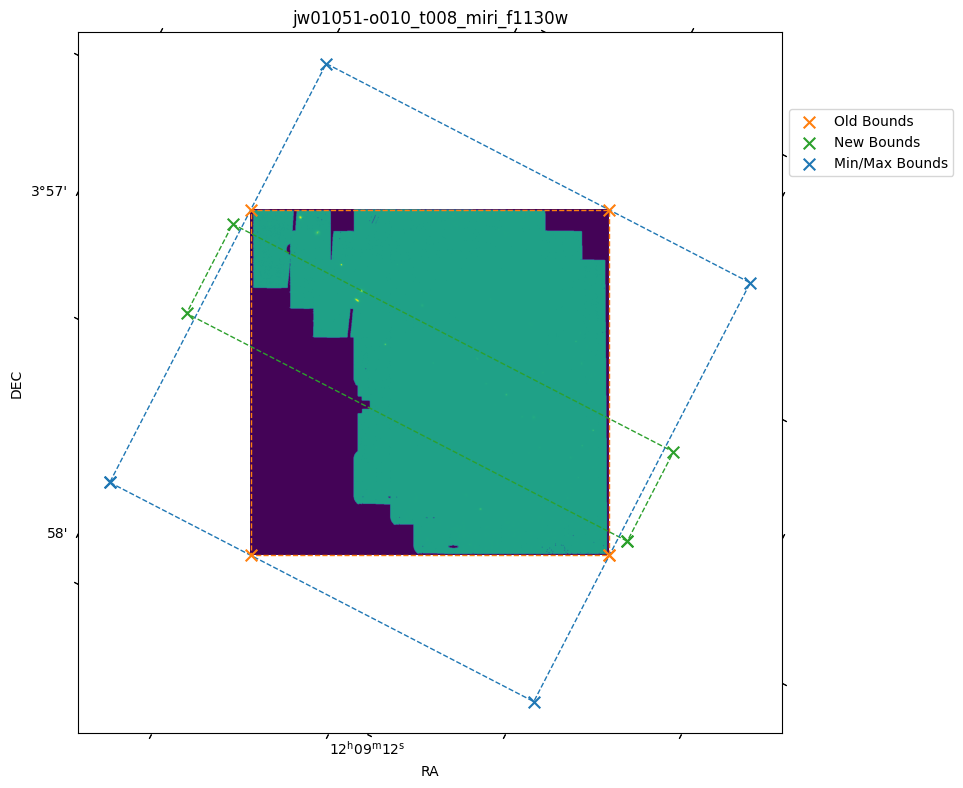

 65%|██████▍   | 31/48 [26:43<13:13, 46.69s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1236                                                  NAXIS2  =                 1189                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =    59726.43130311111 / [d] exposure start time in MJD                 MJD-AVG =   59726.435200197535 / [d] exposure mid-point in MJD                  MJD-END =   59726.438337037034 / [d] exposure end time in MJD                   TDB-BEG =    59726.43459375784 / [d] TDB time of exposure start in MJD          TDB-MID =   59726.438490497174 / [d] TDB

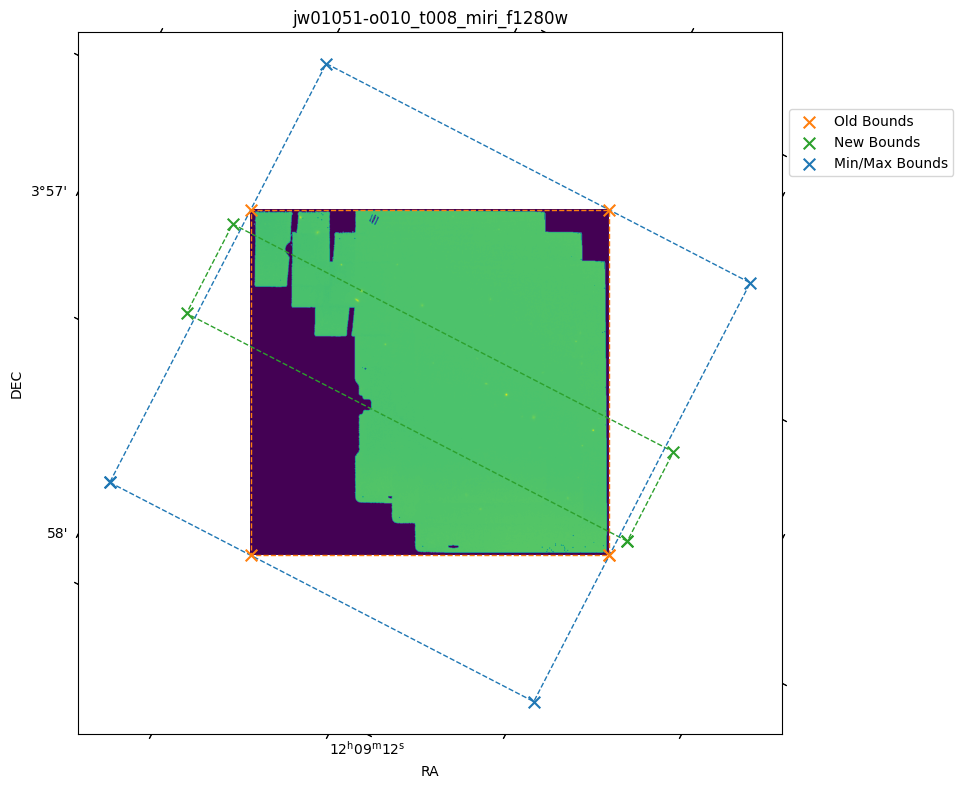

 67%|██████▋   | 32/48 [27:24<11:55, 44.74s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1236                                                  NAXIS2  =                 1189                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =    59726.40563963796 / [d] exposure start time in MJD                 MJD-AVG =    59726.40964390463 / [d] exposure mid-point in MJD                  MJD-END =    59726.41289854167 / [d] exposure end time in MJD                   TDB-BEG =    59726.40893257016 / [d] TDB time of exposure start in MJD          TDB-MID =    59726.41293648026 / [d] TDB

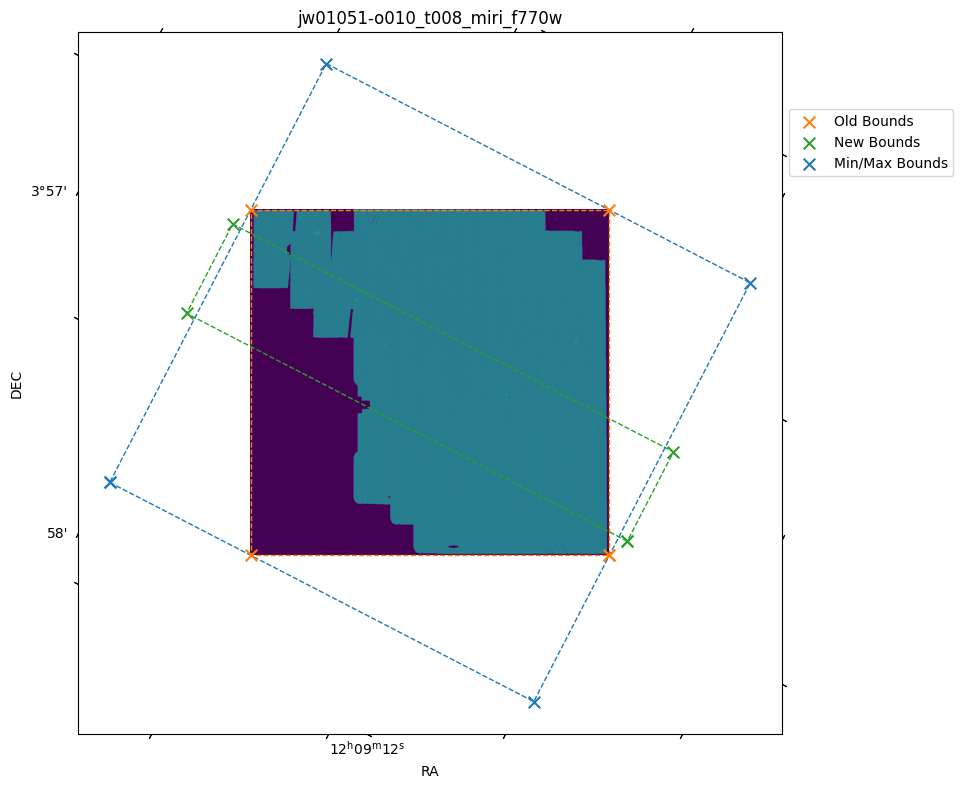

 69%|██████▉   | 33/48 [28:13<11:29, 46.00s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1190                                                  NAXIS2  =                 1104                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =   59730.605813435184 / [d] exposure start time in MJD                 MJD-AVG =    59730.60828657099 / [d] exposure mid-point in MJD                  MJD-END =   59730.610759953706 / [d] exposure end time in MJD                   TDB-BEG =     59730.6087267363 / [d] TDB time of exposure start in MJD          TDB-MID =    59730.61119964544 / [d] TDB

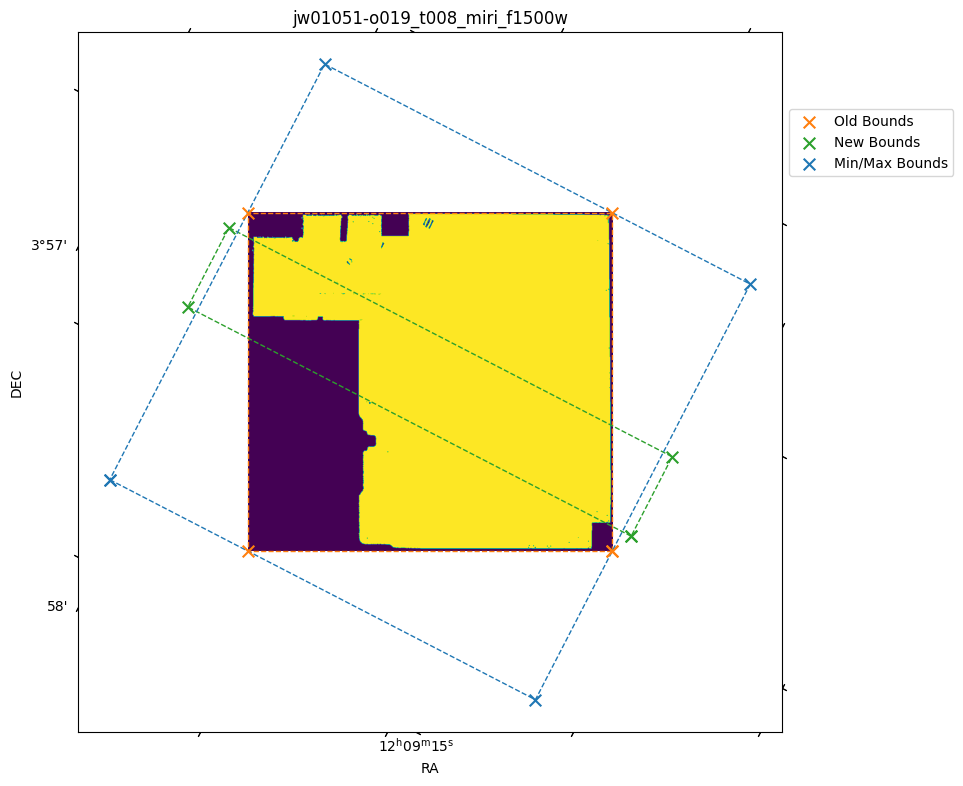

 71%|███████   | 34/48 [29:17<12:00, 51.45s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1190                                                  NAXIS2  =                 1104                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =    59730.61281499398 / [d] exposure start time in MJD                 MJD-AVG =   59730.614415863114 / [d] exposure mid-point in MJD                  MJD-END =    59730.61602734954 / [d] exposure end time in MJD                   TDB-BEG =   59730.615727653414 / [d] TDB time of exposure start in MJD          TDB-MID =    59730.61732837583 / [d] TDB

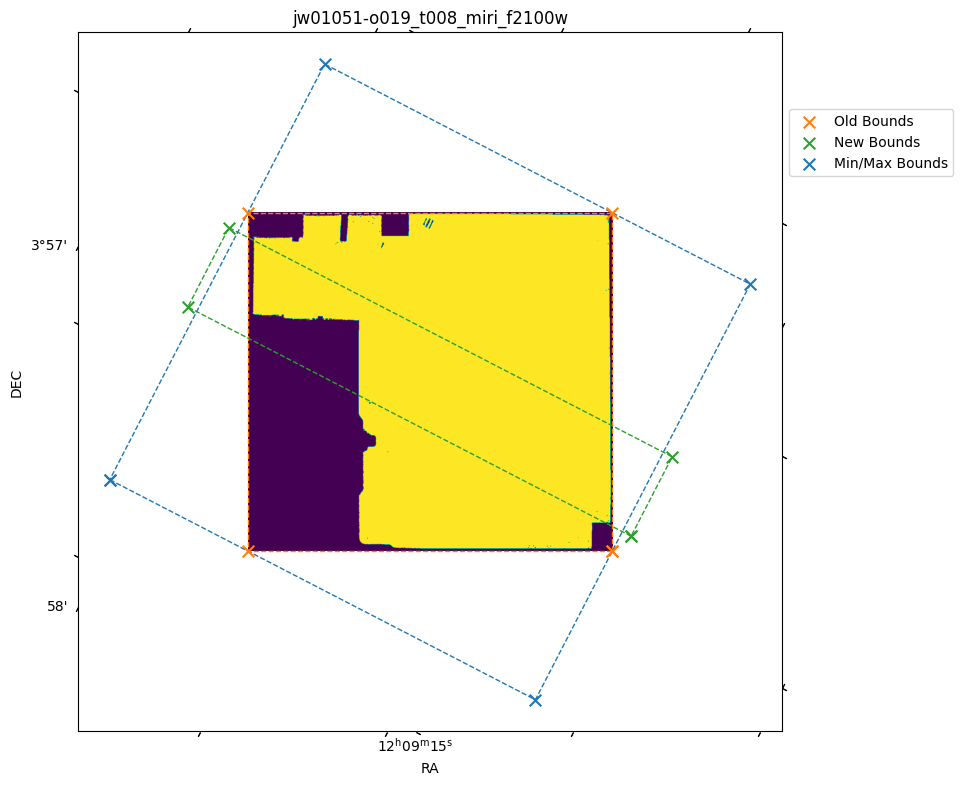

 73%|███████▎  | 35/48 [30:20<11:57, 55.16s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1190                                                  NAXIS2  =                 1104                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =    59730.61837188287 / [d] exposure start time in MJD                 MJD-AVG =    59730.61968875201 / [d] exposure mid-point in MJD                  MJD-END =    59730.62103771991 / [d] exposure end time in MJD                   TDB-BEG =      59730.621284033 / [d] TDB time of exposure start in MJD          TDB-MID =    59730.62260078144 / [d] TDB

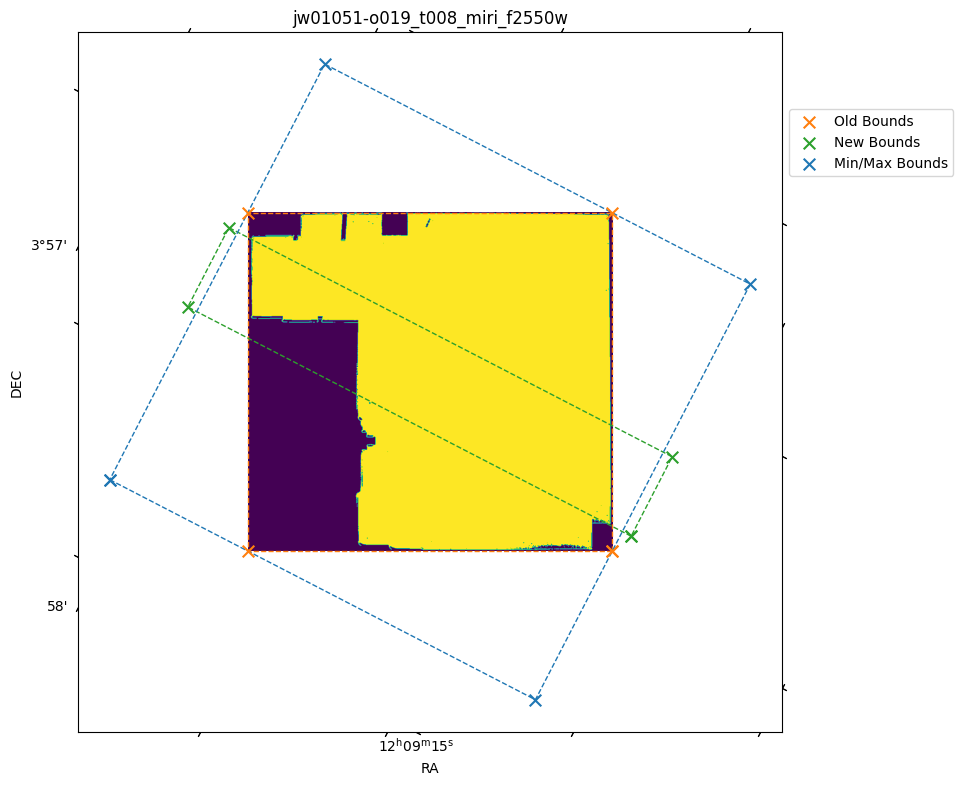

 75%|███████▌  | 36/48 [31:08<10:36, 53.01s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1239                                                  NAXIS2  =                 1156                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =    59730.64580153704 / [d] exposure start time in MJD                 MJD-AVG =    59730.64826430247 / [d] exposure mid-point in MJD                  MJD-END =     59730.6507162037 / [d] exposure end time in MJD                   TDB-BEG =    59730.64871117292 / [d] TDB time of exposure start in MJD          TDB-MID =    59730.65117371259 / [d] TDB

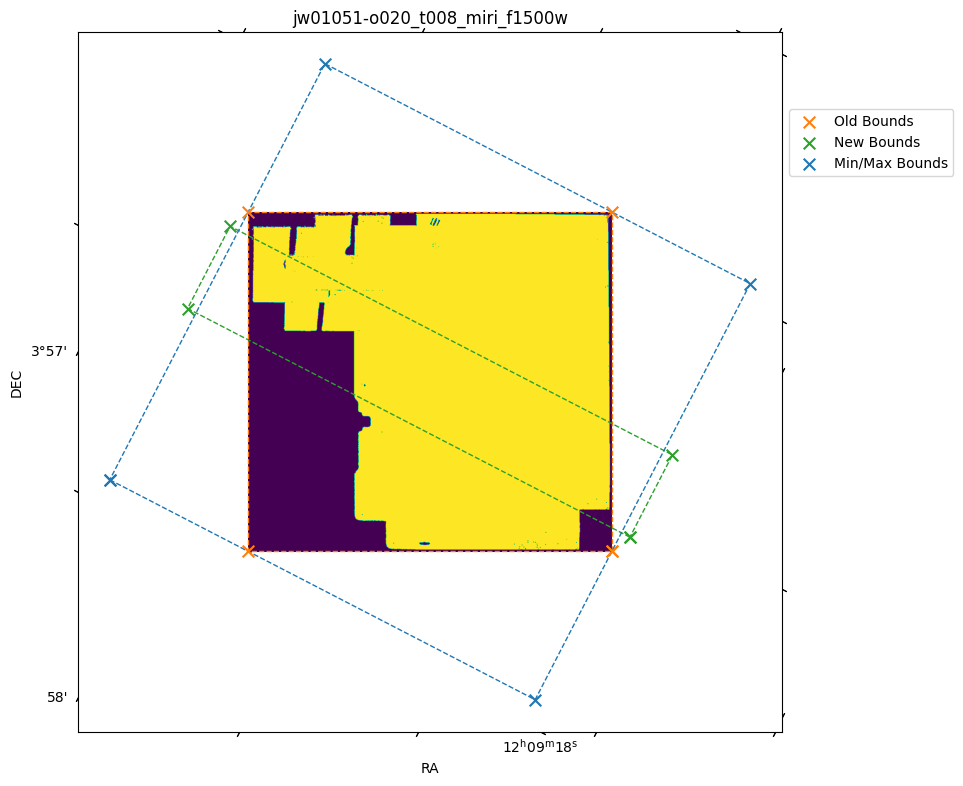

 77%|███████▋  | 37/48 [32:12<10:18, 56.26s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1239                                                  NAXIS2  =                 1156                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =    59730.65280384815 / [d] exposure start time in MJD                 MJD-AVG =    59730.65440447037 / [d] exposure mid-point in MJD                  MJD-END =    59730.65598361111 / [d] exposure end time in MJD                   TDB-BEG =    59730.65571284212 / [d] TDB time of exposure start in MJD          TDB-MID =   59730.657313317606 / [d] TDB

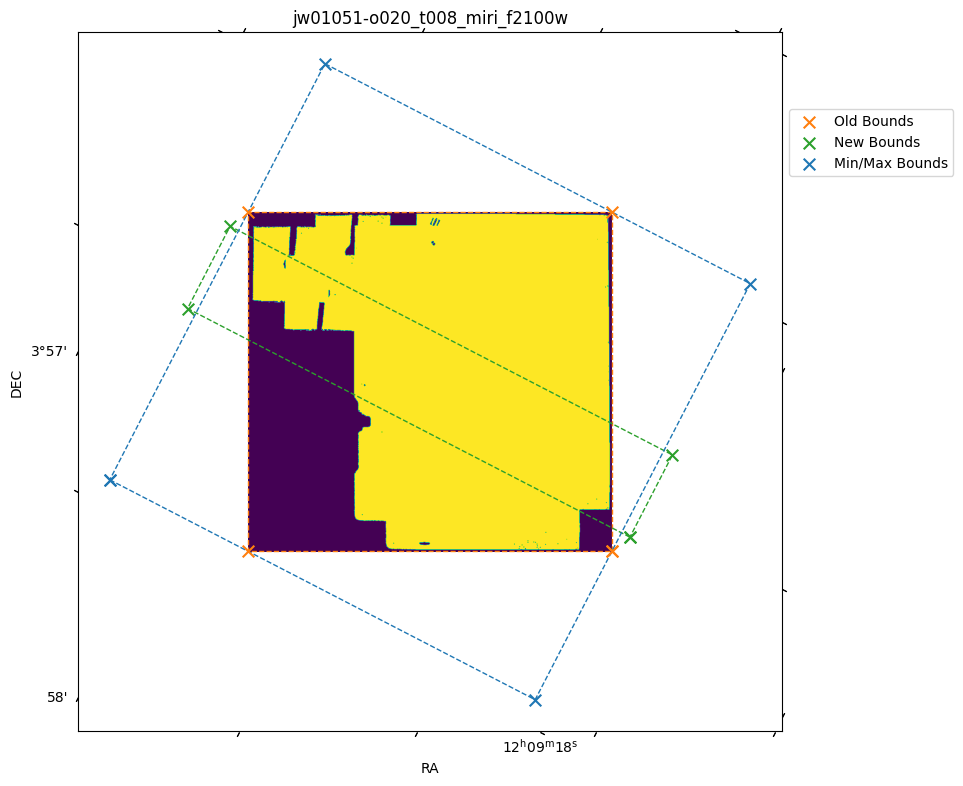

 79%|███████▉  | 38/48 [33:18<09:50, 59.09s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1239                                                  NAXIS2  =                 1156                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =   59730.658392577316 / [d] exposure start time in MJD                 MJD-AVG =     59730.6597521625 / [d] exposure mid-point in MJD                  MJD-END =    59730.66109026621 / [d] exposure end time in MJD                   TDB-BEG =    59730.66130105894 / [d] TDB time of exposure start in MJD          TDB-MID =   59730.662660519476 / [d] TDB

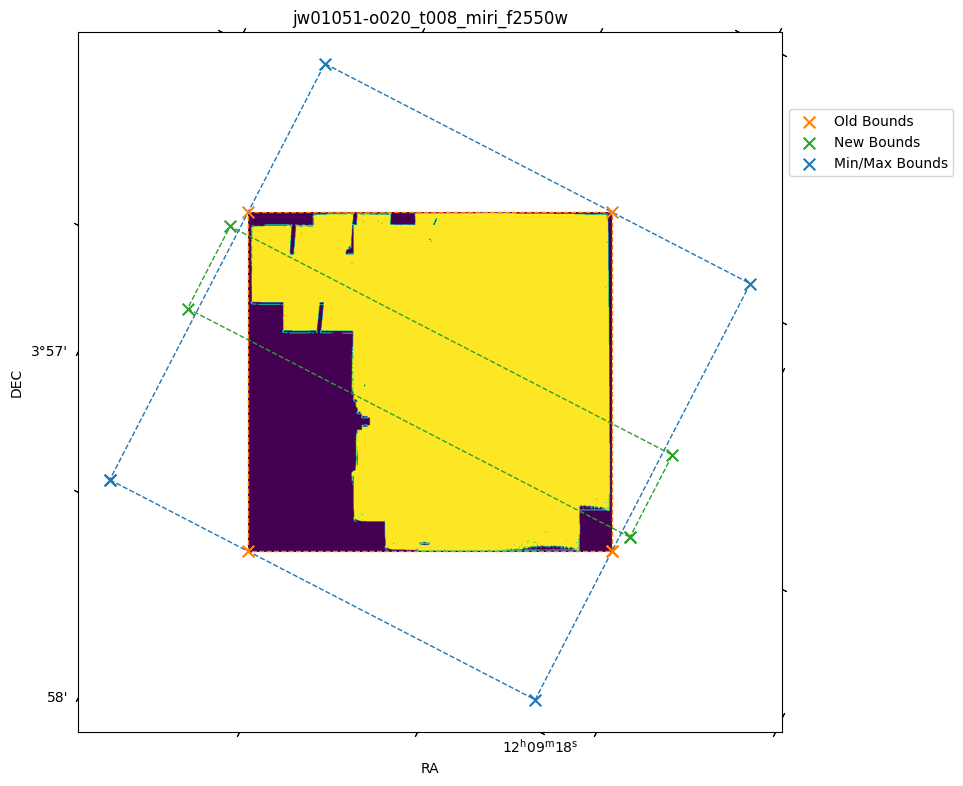

 81%|████████▏ | 39/48 [34:17<08:50, 59.00s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1156                                                  NAXIS2  =                 1230                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =    59730.68450594676 / [d] exposure start time in MJD                 MJD-AVG =    59730.68697883565 / [d] exposure mid-point in MJD                  MJD-END =    59730.68945172454 / [d] exposure end time in MJD                   TDB-BEG =    59730.68741203421 / [d] TDB time of exposure start in MJD          TDB-MID =    59730.68988469635 / [d] TDB

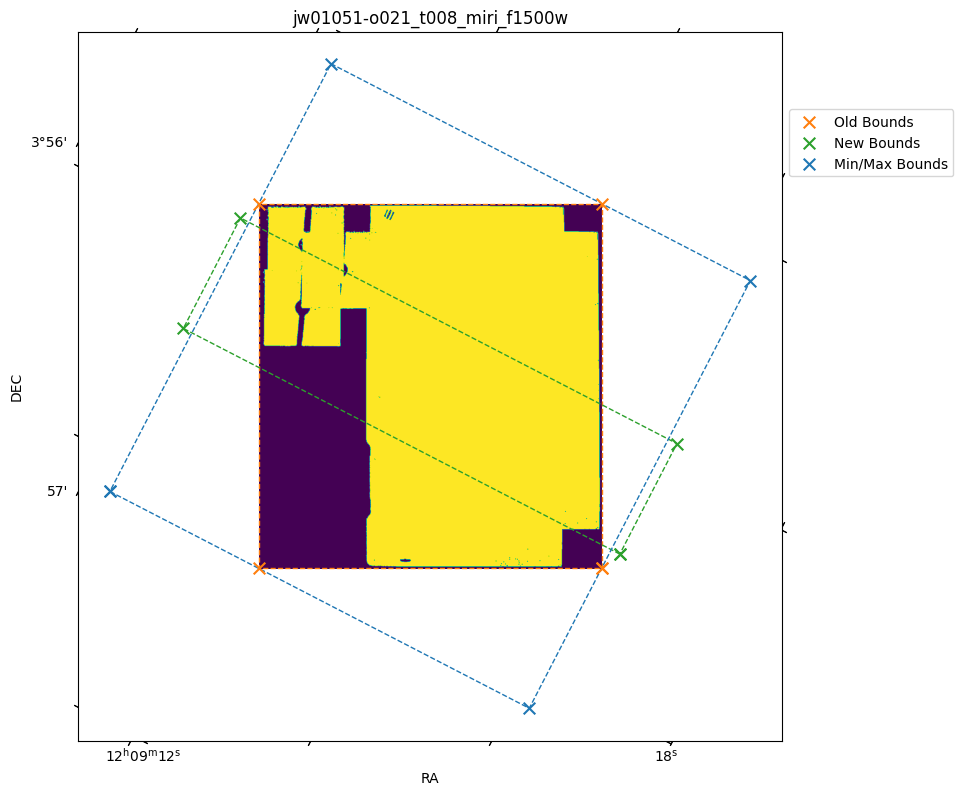

 83%|████████▎ | 40/48 [35:01<07:16, 54.57s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1156                                                  NAXIS2  =                 1230                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =    59730.69147566528 / [d] exposure start time in MJD                 MJD-AVG =    59730.69314023425 / [d] exposure mid-point in MJD                  MJD-END =    59730.69478356482 / [d] exposure end time in MJD                   TDB-BEG =    59730.69438111365 / [d] TDB time of exposure start in MJD          TDB-MID =       59730.69604553 / [d] TDB

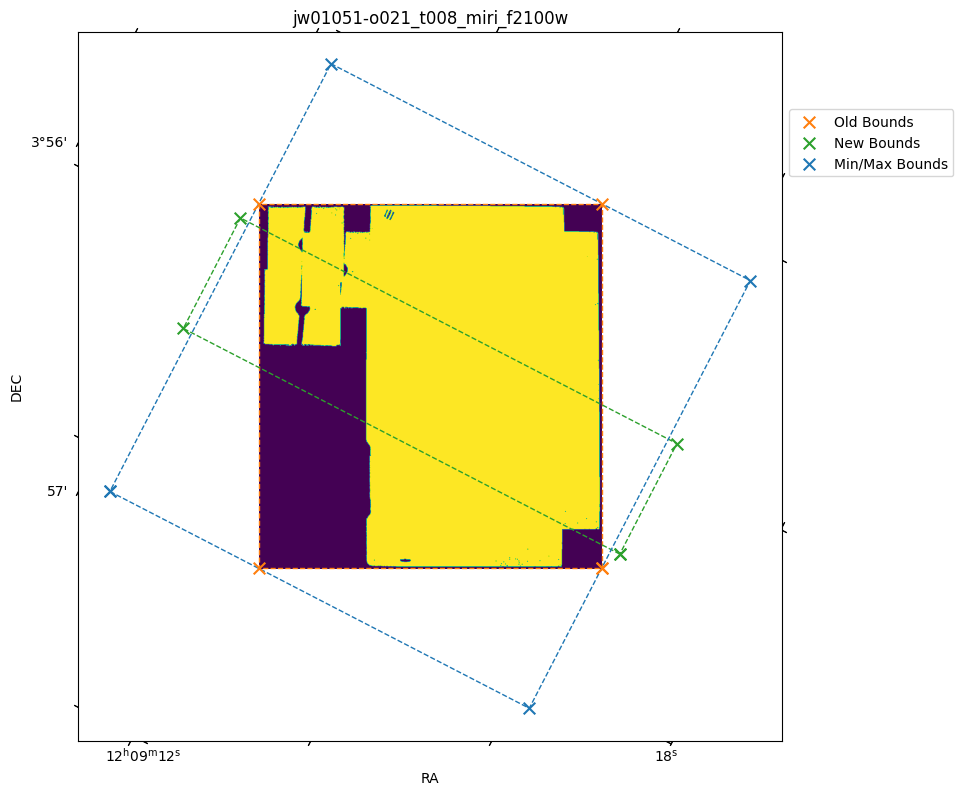

 85%|████████▌ | 41/48 [36:04<06:39, 57.12s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1156                                                  NAXIS2  =                 1230                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =    59730.69716069074 / [d] exposure start time in MJD                 MJD-AVG =     59730.6985632389 / [d] exposure mid-point in MJD                  MJD-END =    59730.69998726852 / [d] exposure end time in MJD                   TDB-BEG =    59730.70006561781 / [d] TDB time of exposure start in MJD          TDB-MID =   59730.701468037354 / [d] TDB

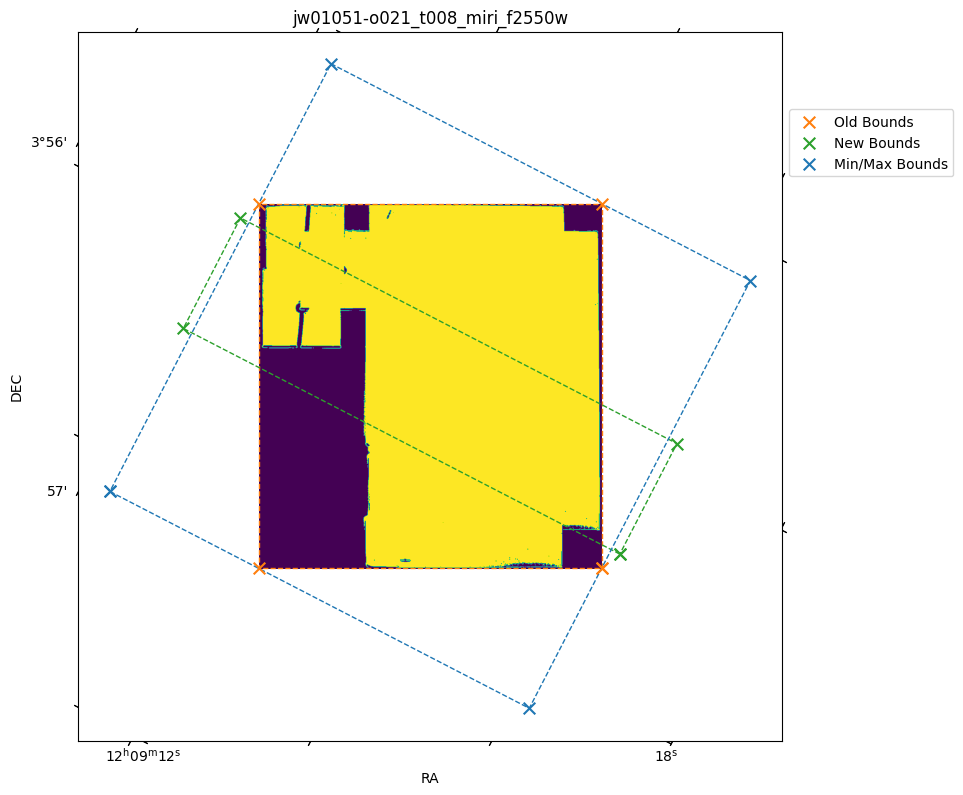

 88%|████████▊ | 42/48 [37:04<05:47, 57.86s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1080                                                  NAXIS2  =                 1230                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =    59730.72545776389 / [d] exposure start time in MJD                 MJD-AVG =    59730.72793089583 / [d] exposure mid-point in MJD                  MJD-END =   59730.730404270835 / [d] exposure end time in MJD                   TDB-BEG =    59730.72836009595 / [d] TDB time of exposure start in MJD          TDB-MID =    59730.73083300108 / [d] TDB

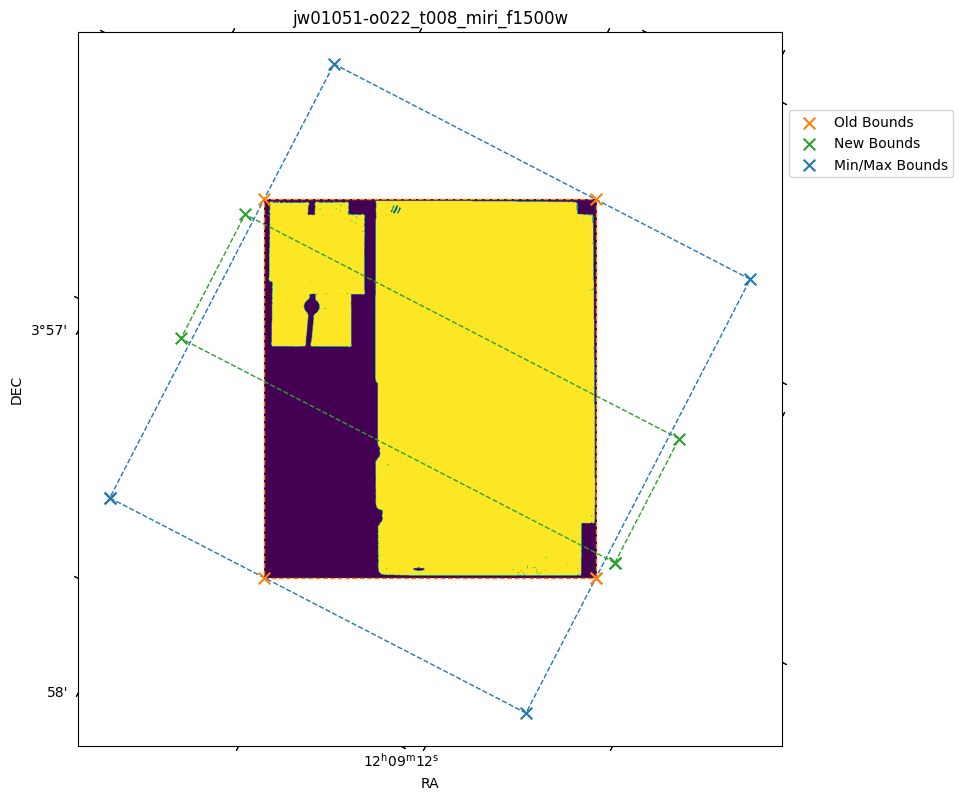

 90%|████████▉ | 43/48 [39:39<07:15, 87.15s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1080                                                  NAXIS2  =                 1229                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =    59730.73245932269 / [d] exposure start time in MJD                 MJD-AVG =    59730.73410315478 / [d] exposure mid-point in MJD                  MJD-END =    59730.73573612268 / [d] exposure end time in MJD                   TDB-BEG =   59730.735361012594 / [d] TDB time of exposure start in MJD          TDB-MID =    59730.73700469392 / [d] TDB

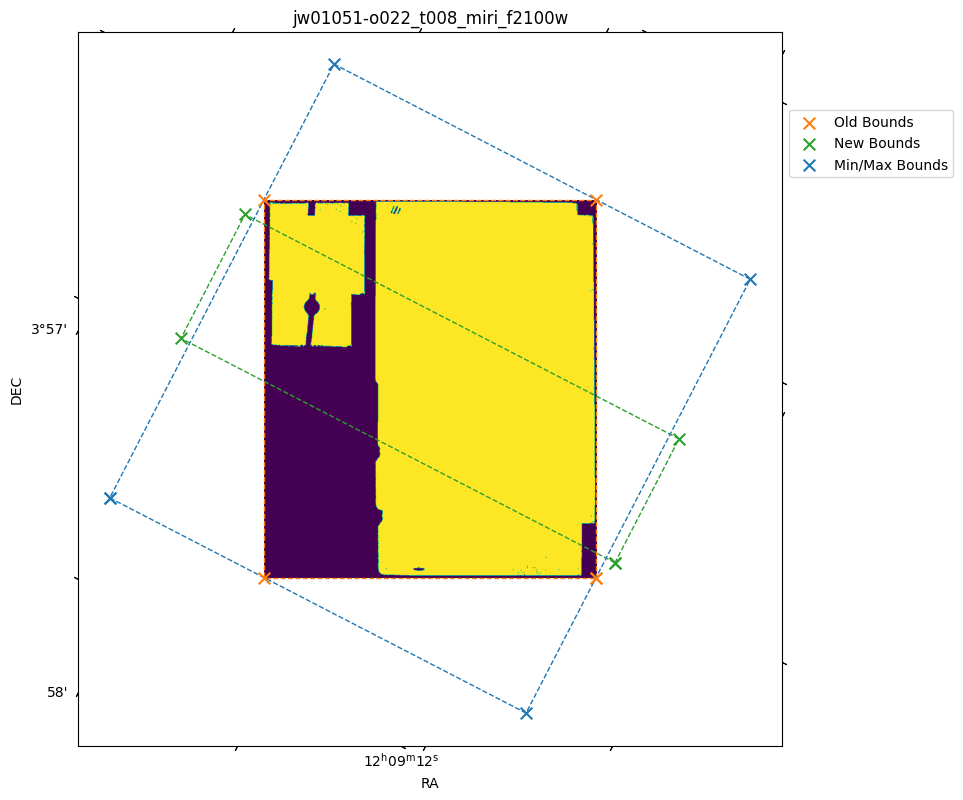

 92%|█████████▏| 44/48 [41:49<06:39, 99.87s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1080                                                  NAXIS2  =                 1230                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =    59730.73814510046 / [d] exposure start time in MJD                 MJD-AVG =    59730.73966517948 / [d] exposure mid-point in MJD                  MJD-END =    59730.74109982639 / [d] exposure end time in MJD                   TDB-BEG =    59730.74104626887 / [d] TDB time of exposure start in MJD          TDB-MID =    59730.74256620845 / [d] TDB

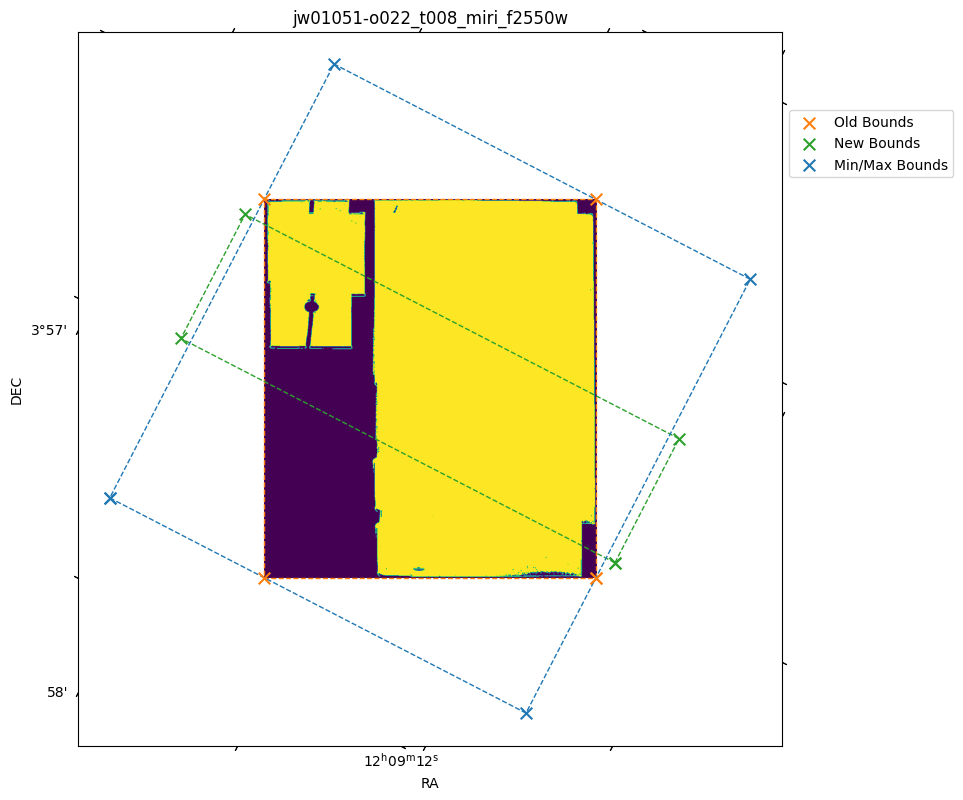

 94%|█████████▍| 45/48 [42:56<04:30, 90.10s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1236                                                  NAXIS2  =                 1189                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =   59730.764385877315 / [d] exposure start time in MJD                 MJD-AVG =   59730.768315301706 / [d] exposure mid-point in MJD                  MJD-END =    59730.77148423611 / [d] exposure end time in MJD                   TDB-BEG =    59730.76728463869 / [d] TDB time of exposure start in MJD          TDB-MID =   59730.771213702596 / [d] TDB

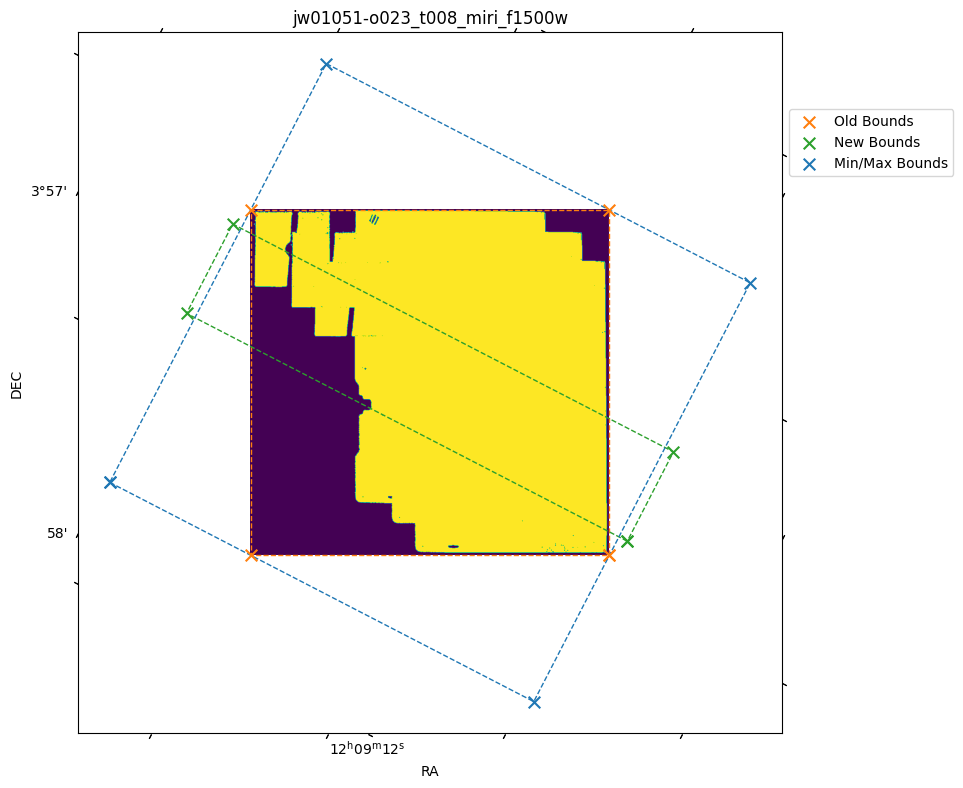

 96%|█████████▌| 46/48 [43:51<02:39, 79.59s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1236                                                  NAXIS2  =                 1189                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =   59730.773508176855 / [d] exposure start time in MJD                 MJD-AVG =    59730.77658632223 / [d] exposure mid-point in MJD                  MJD-END =   59730.778904224535 / [d] exposure end time in MJD                   TDB-BEG =    59730.77640610136 / [d] TDB time of exposure start in MJD          TDB-MID =    59730.77948396434 / [d] TDB

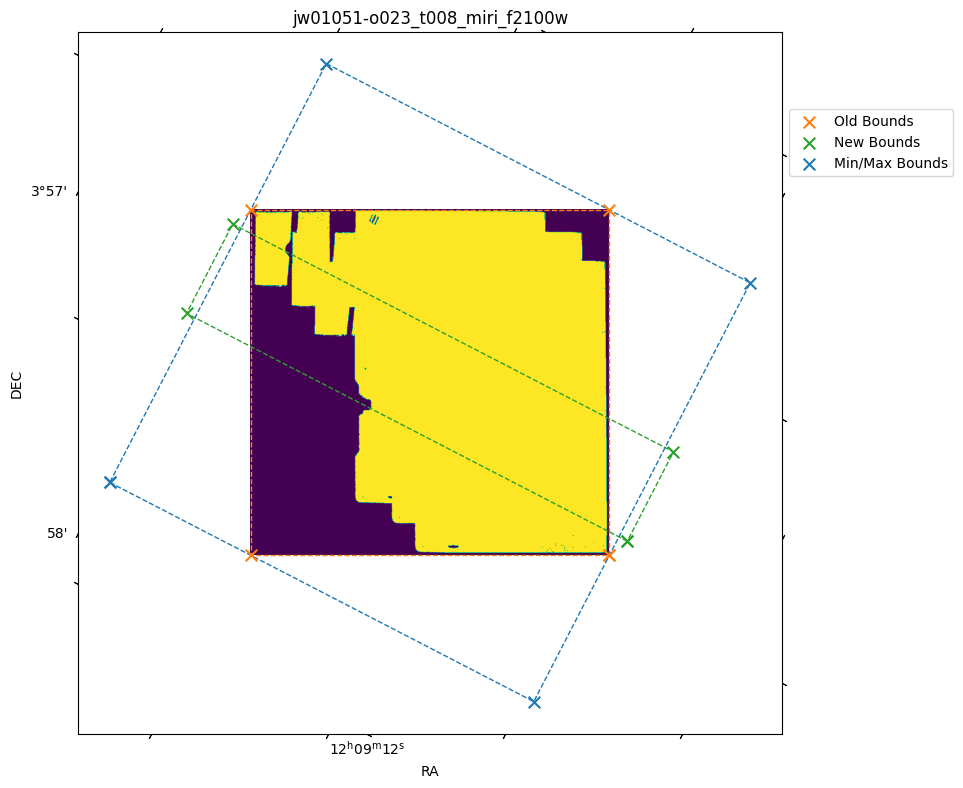

 98%|█████████▊| 47/48 [45:03<01:17, 77.25s/it]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1236                                                  NAXIS2  =                 1189                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SCI     '           / extension name                                 MJD-BEG =    59730.78128060972 / [d] exposure start time in MJD                 MJD-AVG =     59730.7840964912 / [d] exposure mid-point in MJD                  MJD-END =   59730.786162743054 / [d] exposure end time in MJD                   TDB-BEG =    59730.78417782116 / [d] TDB time of exposure start in MJD          TDB-MID =    59730.78699344429 / [d] TDB

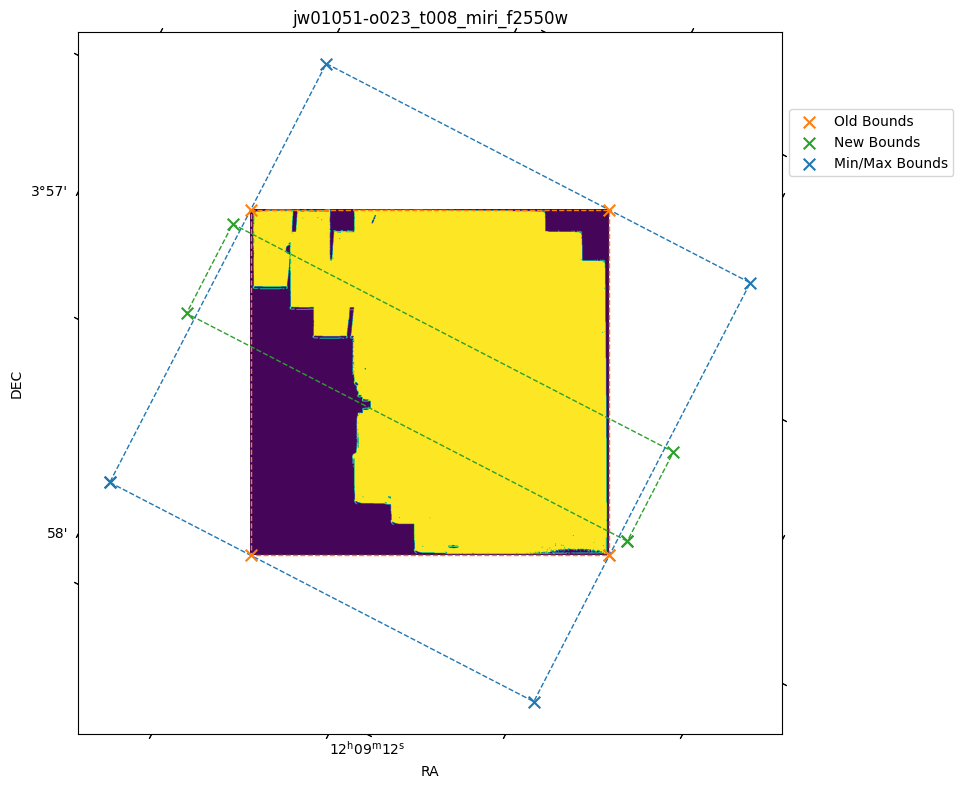

100%|██████████| 48/48 [45:44<00:00, 57.18s/it]


CSV saved to Level3/JWST_NEW_SSO_17_18.csv


In [69]:
save_loc = 'Level3'
PropRange = [17,18]

main(save_loc, PropRange)

In [ ]:
save_loc = 'Level3'
PropRange = [0,10]

main(save_loc, PropRange)